2018 Edition

# Estimating Financial Risk through Monte Carlo Simulation
Risk analysis is part of every decision we make when faced with uncertainty, ambiguity, and variability. Indeed, even though we have unprecedented access to information, we can't accurately predict the future. In finance, there is a fair amount of uncertainty and risk involved with estimating the future value of financial products, due to the wide variety of potential outcomes. Monte Carlo simulation (also known as the Monte Carlo Method) allows inspecting many possible outcomes of the decision making process, and can be used to assess the impact of risk: this, in turns, allows for better decision-making under uncertainty.

## Goals
The main objectives we set for this Notebook are as follows:
1. Develop fundamental knowledge about Risk analysis
2. Understand Monte Carlo Simulation (MCS)
3. Apply Monte Carlo Simulation for predicting risk


## Steps
1. First, in section 1, we introduce the basics of MCS
2. In section 2, we work on a simple example to where we apply the MCS method
3. In section 3, we briefly summarize the main characteristics of the Monte Carlo Simulation (MCS) technique
4. In section 4, we overview the common distributions which are often used in MCS
5. In section 5, we work on a real use case, that focuses on estimating financial risk. We will use techniques such as featurization  (that is, generating additional features to improve model accuracy), linear regression, kernel density estimation, sampling distributions and so on ...

## Reference
This Notebook is inspired by Chapter 9 of the book [Advanced Analytics with Spark](http://shop.oreilly.com/product/0636920035091.do) by Josh Wills, Sandy Ryza, Sean Owen, and Uri Laserson. It is strongly suggested to read this Chapter to get a general idea of the topic of this Notebook.

# 1. Introduction

## 1.1. Monte Carlo Simulation (MCS)
Monte Carlo simulation is a computerized mathematical technique that can be applied such that it is possible to account for risk in quantitative analysis and decision making. This technique is used in many different fields, such as R&D, risk management, portfolio management, pricing derivatives, strategic planning, project planning, cost modeling and many more.

In general, MCS is a technique that "converts" uncertainty on input variables of a model into **probability distributions**. By combining the distributions and randomly selecting values from them, it recalculates the simulated model many times, to determine the probability of the output.

Historically, this technique was first used by scientists working on the atomic bomb: it was named after Monte Carlo, the Monaco resort town renowned for its casinos.  Since its introduction in World War II, Monte Carlo simulation has been used to model a variety of physical and conceptual systems.

## 1.2. How does it work?
Monte Carlo simulation performs risk analysis by building models of possible results by *substituting a range of possible input values, that constitute uncertainty, into a statistical distribution*. It then computes possible outcomes repeatedly, each time using a different set of random values from the probability functions that "model" the input. Depending upon the number of random input variables and their distribution, a Monte Carlo simulation could involve thousands or tens of thousands of "rounds" before it is complete. When complete, *Monte Carlo simulation produces distributions of possible outcome values*.

By using probability distributions instead of actual input samples, it is possible to model more accurately uncertainty: different choices of distributions will yield different outputs.

# 2. Illustrative example

Imagine you are the marketing manager for a firm that is planning to introduce a new product. You need to estimate the first-year net profit from this product, which might depend on:

- Sales volume in units
- Price per unit (also called "Selling price")
- Unit cost
- Fixed costs

Net profit will be calculated as $Net Profit = Sales Volume* (Selling Price - Unit cost) - Fixed costs$.  Fixed costs (accounting for various overheads, advertising budget, etc.) are known to be \$ 120,000, which we assume to be deterministic. All other factors, instead, involve some uncertainty: *sales volume* (in units) can cover quite a large range, the *selling price* per unit will depend on competitor actions, which are hard to predict, and *unit costs* will also vary depending on vendor prices and production experience, for example.

Now, to build a risk analysis model, we must first identify the uncertain variables -- which are essentially random variables.  While there's some uncertainty in almost all variables in a business model, we want to focus on variables where the range of values is significant.

## 2.1. Unit sales and unit price

Based on a hypothetical market research you have done, you have beliefs that there are equal chances for the market to be `slow`, `normal`, or `hot`:

- In a "slow" market, you expect to sell 50,000 units at an average selling price of \$11.00 per unit
- In a "normal" market, you expect to sell 75,000 units, but you'll likely realize a lower average selling price of \$10.00 per unit
- In a "hot" market, you expect to sell 100,000 units, but this will bring in competitors, who will drive down the average selling price to \$8.00 per unit

### Question 1
<div class="alert alert-info">
Calculate the average units and the unit price that you expect to sell, which depend on the market state. Use the assumptions above to compute the expected quantity of products and their expected unit price. 
</div>


In [1]:
average_unit = (50000+75000+100000)/3
average_price = (11.0+10.0+8.0)/3
print("average_unit:", average_unit)
print("average_price:", average_price)

average_unit: 75000.0
average_price: 9.666666666666666


**COMMENT**<br>
As we have equal chances for the market to be slow, normal or hot, we can simply compute the average expected unit and price by considering an equal probability among those, so by multipying by 1/3 each value.

## 2.2. Unit Cost

Another uncertain variable is Unit Cost. In our illustrative example, we assume that your firm's production manager advises you that unit costs may be anywhere from \$5.50 to \$7.50, with a most likely expected cost of \$6.50. In this case, the most likely cost can be considered as the average cost.

## 2.3. A Flawed Model: using averages to represent our random variables
Our next step is to identify uncertain functions -- also called functions of a random variable.  Recall that Net Profit is calculated as $Net Profit = Sales Volume * (Selling Price - Unit cost) - Fixed costs$.  However, Sales Volume, Selling Price and Unit Cost are all uncertain variables, so Net Profit is an uncertain function.

The simplest model to predict the Net Profit is using average of sales volume, average of selling price and average of unit cost for calculating. So, if only consider averages, we can say that the $Net Profit = 75,000*(9.66666666 - 6.5) - 120,000 \sim 117,500$.

However, as [Dr. Sam Savage](http://web.stanford.edu/~savage/faculty/savage/) warns, "Plans based on average assumptions will be wrong on average." The calculated result is far from the actual value: indeed, the **true average Net Profit** is roughly  \$93,000, as we will see later in the example.

### Question 2
#### Question 2.1
<div class="alert alert-info">
Write a function named `calNetProfit` to calculate the Net Profit using the average of sales volume, the average of selling price and the average of unit cost.
</div>

In [2]:
def calNetProfit(average_unit, average_price, average_unitcost, fixed_cost):
    return average_unit*(average_price-average_unitcost)-fixed_cost

In [3]:
average_unitcost = 6.5
fixed_cost = 120000
NetProfit = calNetProfit(average_unit, average_price, average_unitcost, fixed_cost)
print("Net profit: %.2f" % NetProfit)

Net profit: 117500.00


#### Question 2.2
<div class="alert alert-info">
Verify the warning message of Dr. Sam Savage by calculating the error of our estimated Net Profit using averages only. Recall that the true value is roughly \$93,000, so we are interested in:
<ul></ul>

$$ error = \frac{your\_value - true\_value}{true\_value}$$

<ul></ul>
Note also we are interested in displaying the error as a percentage.
<ul></ul>
Looking at the error we make, do you think that we can use the current model that only relies on averages?
</div>

In [4]:
def computeError(NetProfit, trueNetProfit):
    return (NetProfit - trueNetProfit) / (trueNetProfit)

In [5]:
trueNetProfit = 93000
error = computeError(NetProfit, trueNetProfit)
print("Error in percentage: %.2f%%" % (error * 100))

Error in percentage: 26.34%


**COMMENT**<br>
Got a 26% error: this is too large and definitively not acceptable. So we can conclude that using a simple average for predicting the net profit is not the right way to proceed and is not a reliable method for taking critical decisions.

## 2.4. Using the Monte Carlo Simulation method to improve our model
As discussed before, the selling price and selling volume both depend on the state of the market scenario (slow/normal/hot). So, the net profit is the result of two random variables: `market scenario` (which in turn determines `sales volumes` and `selling price`) and `unit cost`.

Now, let's assume (this is an *a-priori* assumption we make) that `market scenario` follows a discrete, uniform distribution and that `unit cost` also follows a uniform distribution. Then, we can compute directly the values for selling price and selling volumes based on the outcome of the random variable `market scenario`, as shown in Section 2.1.

From these a-priori distributions, in each run (or trial) of our Monte Carlo simulation, we can generate the sample value for each random variable and use it to calculate the Net Profit. The more simulation runs, the more accurate our results will be. For example, if we run the simulation 100,000 times, the average net profit will amount to roughly \$92,600. Every time we run the simulation, a different prediction will be output: the average of such predictions will consistently be less than \$117,500, which we predicted using averages only.

Note also that in this simple example, we generate values for the `market scenario` and `unit cost` independently: we consider them to be **independent random variables**. This means that the eventual (and realistic!) correlation between the `market scenario` and `unit cost` variables is ignored. Later, we will learn how to be more precise and account for dependency between random variables.


### Question 3
#### Question 3.1
<div class="alert alert-info">
Write a function named `get_sales_volume_price` that returns the sales volume and price based on the market scenario. In particular, the scenario can get one of three values:
<ul>
  <li>0: Slow market</li>
  <li>1: Normal market</li>
  <li>2: Hot market</li>
</ul>  

The return value is a tuple in the form: `(sales_volume, price)`
</div>

In [6]:
# Get sales volume and  price based on market scenario
# the function returns a tuple of (sales_volume, price)
def get_sales_volume_price(scenario):
    # Slow market
    if scenario == 0:
        return (50000, 11.0)
    # Normal market
    if scenario == 1:
        return (75000, 10.0)
    # Hot market
    if scenario == 2:
        return (100000, 8.0)

#### Question 3.2
<div class="alert alert-info">
Run 100,000 Monte Carlo simulations and calculate the average net profit they produce. Then, compare the result to the "average model" we used in the previous questions (the one we called "flawed" model). Put your comments about the discrepancies between a simplistic model, and the more accurate MCS approach.  
<ul></ul>
Note that in each iteration, the `unit_cost` and `market_scenario` are generated according to their distributions. Also, recall what we have seen in Section 2.2: your firm account manager helped you with some research, to determine the variability of your random variables.  
</div>


<div class="label label-success">HINT</div>  

Function `uniform(a,b)` in module `random` generates a number $a<=c<=b$, which is drawn from a uniform distribution.  

Function `randint(a,b)` helps you generating an integer number $a<=c<=b$

In [7]:
import random
import numpy as np

def run_MC_simulations(simulations, fixed_cost):
    total = 0.0
    for i in range(0, simulations):
        unit_cost = np.random.uniform(5.5, 7.5)
        market_scenario = np.random.randint(0,3)
        sales_volume, price = get_sales_volume_price(market_scenario)
        netProfit = calNetProfit(sales_volume, price, unit_cost, fixed_cost)
        total += netProfit
    return total

In [8]:
for simulations in [1000, 10000, 100000]:
    total = run_MC_simulations(simulations, fixed_cost)
    print("######", simulations, "simulations", "######")
    print("Average net profit: %.2f" % (total/simulations))
    print("Error: %.2f%%\n" % (computeError(total/simulations, trueNetProfit)*100))

###### 1000 simulations ######
Average net profit: 96618.64
Error: 3.89%

###### 10000 simulations ######
Average net profit: 92501.69
Error: -0.54%

###### 100000 simulations ######
Average net profit: 92597.27
Error: -0.43%



**COMMENT**<br>
In this case we decided to run multiple "simulations", each with a different (increasing) number of simulations among which it is then computed the average. In particular we have tried with 1'000, 10'000 and 100'000 simulations.<br>
As expected, the results obtained with the "average model" are always better than the one obtained above with the "flawed model". In fact, in this case the error is always less than ~6%, which is a noticeable difference if compared to the 26% of above (obviously, if we execute the code multiple times we always get different values, but it is always far from 26%).<br>
Moreover, it is also interesting to notice that (generally!) the error decreases as it increases the number of different runs of the algorithm. This confirms what said above: "the more simulation runs, the more accurate our results will be"; with 100'000 simulations in fact, we obtain a result that is very close to the true net profit. We said generally because it does not happen everytime; sometimes in fact it can happen for example that with 1000 simulations we obtain a better results than with 10000, but ideally we can expect an improvement as the we increase the simulations.

Another interesting thing to notice is that all the error obtained are usually negatives...let's make some additional test...

In [9]:
p = 0
n = 0
for i in range(100):
    simulations = 100000
    total = run_MC_simulations(simulations, fixed_cost)
    error = computeError(total/simulations, trueNetProfit)*100
    if(error > 0):
        p += 1
    else:
        n += 1
print("Positive errors:", p)
print("Negative errors:", n)

Positive errors: 0
Negative errors: 100


**COMMENT**<br>
As assumed above, the average net profit computed using the monte carlo simulation is likely to be lower than the true net profit: by running 100 times the entire loop (with 100'000 simulations each), we generally get 1 positive error, and 99 negative ones. As before, multiple runs might alter the results; for example it often happens that we get no positive errors but all negative ones.


# 3. A brief summary of the Monte Carlo Simulation (MCS) technique

- A MCS allows several inputs to be used at the same time to compute the probability distribution of one or more outputs
- Different types of probability distributions can be assigned to the inputs of the model, depending on any *a-priori* information that is available. When the distribution is completely unknown, a common technique is to use a distribution computed by finding the best fit to the data you have
- The MCS method is also called a **stochastic method** because it uses random variables. Note also that the general assumption is for input random variables to be independent from each other. When this is not the case, there are techniques to account for correlation between random variables.
- A MCS generates the output as a range instead of a fixed value and shows how likely the output value is to occur in that range. In other words, the model outputs a probability distribution.

# 4. Common distributions used in MCS
In what follows, we summarize the most common probability distributions that are used as *a-priori* distributions for input random variables:

- *Normal/Gaussian Distribution*: this is a continuous distribution applied in situations where the mean and the standard deviation of a given input variable are given, and the mean represents the most probable value of the variable. In other words, values "near" the mean are most likely to occur.  This is symmetric distribution, and it is not bounded in its co-domain. It is very often used to  describe natural phenomena, such as people’s heights, inflation rates, energy prices, and so on and so forth. An illustration of a normal distribution is given below:
![normal_distribution](https://upload.wikimedia.org/wikipedia/commons/thumb/7/74/Normal_Distribution_PDF.svg/320px-Normal_Distribution_PDF.svg.png)

- *Lognormal Distribution*: this is a distribution which is appropriate for variables taking values in the range $[0, \infty]$. Values are positively skewed, not symmetric like a normal distribution.  Examples of variables described by some lognormal distributions include, for example, real estate property values, stock prices, and oil reserves. An illustration of a lognormal distribution is given below:
![log_normal_distribution](https://upload.wikimedia.org/wikipedia/commons/thumb/a/ae/PDF-log_normal_distributions.svg/320px-PDF-log_normal_distributions.svg.png) 

- *Triangular Distribution*: this is a continuous distribution with fixed minimum and maximum values. It is bounded by the minimum and maximum values and can be either symmetrical (the most probable value = mean = median) or asymmetrical. Values around the most likely value (e.g. the mean) are more likely to occur.  Variables that could be described by a triangular distribution include, for example, past sales history per unit of time and inventory levels. An illustration of a triangular distribution is given below:
![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/45/Triangular_distribution_PMF.png/320px-Triangular_distribution_PMF.png)

- *Uniform Distribution*: this is a continuous distribution bounded by known minimum and maximum values. In contrast to the triangular distribution, the likelihood of occurrence of the values between the minimum and maximum is the same. In other words, all values have an equal chance of occurring, and the distribution is simply characterized by the minimum and maximum values. Examples of variables that can be described by a uniform distribution include manufacturing costs or future sales revenues for a new product. An illustration of the uniform distribution is given below:
![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/96/Uniform_Distribution_PDF_SVG.svg/320px-Uniform_Distribution_PDF_SVG.svg.png)

- *Exponential Distribution*: this is a continuous distribution used to model the time that pass between independent occurrences, provided that the rate of occurrences is known. An example of the exponential distribution is given below:
![](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Exponential_pdf.svg/320px-Exponential_pdf.svg.png)

- *Discrete Distribution* : for this kind of distribution, the "user" defines specific values that may occur and the likelihood of each of them.  An example might be the results of a lawsuit: 20% chance of positive verdict, 30% change of negative verdict, 40% chance of settlement, and 10% chance of mistrial.


# 5. A real use case: estimating the financial risk of a portfolio of stocks
We hope that by now you have a good understanding about Monte Carlo simulation. Next, we apply this method to a real use case: *financial risk estimation*.

Imagine that you are an investor on the stock market. You plan to buy some stocks and you want to estimate the maximum loss you could incur after two weeks of investing. This is the quantity that the financial statistic "Value at Risk" (VaR) seeks to measure. [VaR](https://en.wikipedia.org/wiki/Value_at_risk) is defined as a measure of investment risk that can be used as a reasonable estimate of the maximum probable loss for a value of an investment portfolio, over a particular time period. A VaR statistic depends on three parameters: a portfolio, a time period, and a confidence level. A VaR of 1 million dollars with a 95% confidence level over two weeks, indicates the belief that the portfolio stands only a 5% chance of losing more than 1 million dollars over two weeks. VaR has seen widespread use across financial services organizations. This statistic plays a vital role in determining how much cash investors must hold to meet the credit ratings that they seek. In addition, it is also used to understand the risk characteristics of large portfolios: it is a good idea to compute the VaR before executing trades, such that it can help take informed decisions about investments. 

Our goal is calculating VaR of two weeks interval with 95% confidence level and the associated [VaR confidence interval](http://www.investopedia.com/ask/answers/041615/whats-difference-between-confidence-level-and-confidence-interval-value-risk-var.asp).


## 5.1. Terminology
In this use case, we will use some terms that might require a proper definition, given the domain. This is what we call the *Domain Knowledge*.

- **Instrument**: A tradable asset, such as a bond, loan, option, or stock investment. At any particular time, an instrument is considered to have a value, which is the price for which it can be sold. In the use case of this notebook, instruments are stock investments.
- **Portfolio**: A collection of instruments owned by a financial institution. 
- **Return**: The change in an instrument or portfolio’s value over a time period. 
- **Loss**: A negative return. 
- **Index**: An imaginary portfolio of instruments. For example, the NASDAQ Composite index includes about 3,000 stocks and similar instruments for major US and international companies. 
- **Market factor**: A value that can be used as an indicator of macro aspects of the financial climate at a particular time. For example, the value of an index, the Gross Domestic Product of the United States, or the exchange rate between the dollar and the euro. We will often refer to market factors as just factors.

## 5.2. The context of our use case
We have a list of instruments that we plan to invest in. The historical data of each instrument has been collected for you. For simplicity, assume that the returns of instruments at a given time, depend on 4 market factors only: 

- GSPC value
- IXIC value 
- The return of crude oil
- The return of treasury bonds

Our goal is building a model to predict the loss after two weeks' time interval with confidence level set to 95%.

As a side note, it is important to realize that the approach presented in this Notebook is a simplified version of what would happen in a real Financial firm. For example, the returns of instruments at a given time often depend on more than 4 market factors only! Moreover, the choice of what constitute an appropriate market factor is an art!



## 5.3. The Data
The stock data can be downloaded (or scraped) from Yahoo! by making a series of REST calls. The data includes multiple files. Each file contains the historical information of each instrument that we want to invest in. The data is in the following format (with some samples):
```
Date, Open, High, Low, Close, Volume, Adj Close
2016-01-22,66.239998,68.07,65.449997,67.860001,137400,67.860001
2016-01-21,65.410004,66.18,64.459999,65.050003,148000,65.050003
2016-01-20,64.279999,66.32,62.77,65.389999,141300,65.389999
2016-01-19,67.720001,67.989998,64.720001,65.379997,178400,65.379997
```

The data of GSPC and IXIC values (our two first market factors) are also available on Yahoo! and use the very same format. 

The crude oil and treasure bonds data is collected from investing.com, and has a different format, as shown below (with some samples):
```
Date    Price   Open    High    Low     Vol.    Change %
Jan 25, 2016    32.17   32.36   32.44   32.10   -       -0.59%
Jan 24, 2016    32.37   32.10   32.62   31.99   -       0.54%
Jan 22, 2016    32.19   29.84   32.35   29.53   -       9.01%
Jan 21, 2016    29.53   28.35   30.25   27.87   694.04K 11.22%
Jan 20, 2016    26.55   28.33   28.58   26.19   32.11K  -6.71%
Jan 19, 2016    28.46   29.20   30.21   28.21   188.03K -5.21%
```

In our use case, the factors' data will be used jointly to build a statistical model: as a consequence, we first need to preprocess the data to proceed.

## 5.4. Data preprocessing
In this Notebook, all data files have been downloaded for you, such that you can focus on pre-processing. Next, we will:

  - Read the factor data files which are in two different formats, process and merge them together
  - Read the stock data and pre-process it
  - Trim all data into a specific time region
  - Fill in the missing values
  - Generate the data of returns in each two weeks' time interval window
  
### Factor data pre-processing

We need two functions to read and parse data from Yahoo! and Investing.com respectively. We are interested only in information about the time and the corresponding returns of a factor or an instrument: as a consequence, we will project away many columns of our RAW data, and keep only the information we are interested in.

The 3000-instrument and the 4-factor history are small enough to be read and processed locally: we do not need to use the power of parallel computing to proceed. Note that this is true also for larger cases with hundreds of thousands of instruments and thousands of factors. The need for a distributed system like Spark comes in when actually **running** the Monte Carlo simulations, which can require massive amounts of computation on each instrument. 

### Question 4
#### Question 4.1
<div class="alert alert-info">
Write a function named `readInvestingDotComHistory` to parse data from investing.com based on the format specified above (see Section 5.3). Recall that we use two factors here: one that is related to the price of crude oil, one that is related to some specific US bonds. 

<ul></ul>

Print the first 5 entries of the first factor (crude oil price) in the parsed data.

<ul></ul>

Note that we are only interested in the date and price of stocks.

</div>

<div class="label label-success">HINT</div>  
You can parse a string to `datetime` object by using the function `strptime(<string>, <dtime_format>)`. In this case, the datetime format is `"%b %d, %Y"`. For more information, please follow this [link](https://docs.python.org/2/library/datetime.html#strftime-and-strptime-behavior).

In the next cell, we simply copy data from our HDFS cluster (that contains everything we need for this Notebook) to the instance (a Docker container) running your Notebook. This means that you will have "local" data that you can process without using Spark. Note the folder location: find and verify that you have correctly downloaded the files!

In [10]:
! [ -d monte-carlo-risk ] || (echo "Downloading prepared data from HDFS. Please wait..." ; hdfs dfs -copyToLocal /datasets/monte-carlo-risk . ; echo "Done!";)

In [11]:
from datetime import datetime
from datetime import timedelta
from itertools import islice
%matplotlib inline
import numpy as np
import statsmodels.api as sm
import matplotlib.dates

base_folder = "monte-carlo-risk/"

factors_folder= base_folder + "factors/"

# read data from local disk
def readInvestingDotComHistory(fname, delimiter='\t'):
    def process_line(line):
        cols = line.split(delimiter)
        date = datetime.strptime(cols[0], "%b %d, %Y")
        value = float(cols[1])
        return (date, value)
    
    with open(fname) as f:
        content_w_header = f.readlines()
        # remove the first line 
        # and reverse lines to sort the data by date, in ascending order
        content = content_w_header[:0:-1]
        return list(map(process_line , content))

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


It follows an alternative version of the function implemented above for managing monthly aggregated data. It will be used to read data taken from investing.com (and in particular to prepare the data for the candel sticks below).<br>
A different implementation is needed to read and manage a slightly different format.

In [12]:
# read data from local disk
# investing.com, monthly (there is one row for each month)
# this is useful for representing clearly the trend of the stock 
def readInvestingDotComMonthlyHistory(fname, delimiter='\t'):
    def process_line(line):
        cols = line.split(delimiter)
        date = matplotlib.dates.date2num(datetime.strptime(cols[0].strip('"'), "%b %y"))
        price = float(cols[1].strip('"').replace(',', ''))
        open_ = float(cols[2].strip('"').replace(',', ''))
        high = float(cols[3].strip('"').replace(',',''))
        low = float(cols[4].strip('"').replace(',', ''))
        if(len(cols) > 6):
            volume = float(cols[5].strip('"').replace(',', '').replace('K','000').replace('M','000000').replace('B','000000000'))
            change = float(cols[6].strip("\n").replace(',', ''))
            return (date, open_, price, high, low, volume, change)
        else:
            change = float(cols[5].strip("\n").replace(',', ''))
            return (date, open_, price, high, low, change)
    
    with open(fname) as f:
        content_w_header = f.readlines()
        # remove the first line 
        # and reverse lines to sort the data by date, in ascending order
        content = content_w_header[:0:-1]
        return list(map(process_line , content))

So we read the same information from both the sources: daily and monthly aggregated:

In [13]:
# read "standard" investing.com data
factor1_files = ['crudeoil.tsv', 'us30yeartreasurybonds.tsv']
factor1_files_map = map(lambda fn: factors_folder + fn, factor1_files)
factors1 = [readInvestingDotComHistory(f) for f in factor1_files_map]

print(factors1[0][0:5])

[(datetime.datetime(2006, 1, 26, 0, 0), 66.26), (datetime.datetime(2006, 1, 27, 0, 0), 67.76), (datetime.datetime(2006, 1, 30, 0, 0), 68.35), (datetime.datetime(2006, 1, 31, 0, 0), 67.92), (datetime.datetime(2006, 2, 1, 0, 0), 66.56)]


In [14]:
# read monthly investing.com data
factor1_files_month = ['Crude_Oil_monthly.tsv', 'us30ytreasurybonds_monthly.tsv']
factor1_files_map_month = map(lambda fn: factors_folder + fn, factor1_files_month)
factors1_month = [readInvestingDotComMonthlyHistory(f) for f in factor1_files_map_month]

print(factors1_month[0][0:5])

[(732312.0, 61.04, 67.92, 69.2, 60.81, 2.15, 11.27), (732343.0, 67.8, 61.41, 69.0, 57.55, 2.26, -9.58), (732371.0, 61.58, 66.63, 67.3, 59.25, 2.3, 8.5), (732402.0, 66.25, 71.88, 75.35, 65.6, 2.07, 7.88), (732432.0, 71.7, 71.29, 74.99, 67.42, 2.46, -0.82)]


Now, the data structure `factors1` is a list, containing data that pertains to two (out of a total of four) factors that influence the market, as obtained by investing.com. Each element in the list is a tuple, containing some sort of timestamp, and the value of one of the two factors discussed above. From now on, we call these elements "**records**" or "**entries**". Visually, `factors1` looks like this:

| 0 (crude oil) | 1 (US bonds)|
| --- | --- |
| time_stamp, value | time_stamp, value |
| ... | ... |
| time_stamp, value | time_stamp, value |
| ... | ... |


In [15]:
import matplotlib.pyplot as plt
import matplotlib.finance
import matplotlib.dates as mdates

# function used to plot the factor given as a parameter
def plot_factor(factor, title):
    fig = plt.figure(figsize=(20,8))
    plt.plot([x[0] for x in factor], [x[1] for x in factor])
    plt.title(title)
    plt.show()

# function used to plot the "candlestick"
# quotes is a tuple containing the data (in float format), and following all the information related to the 
# factor: open, close, high, low...
# A red candle represents a decreasing stock value, whereas a green candle represents an increasing value for the stock
def plot_candlestick(quotes, title):
    fig = plt.figure(figsize=(20,8))
    ax = plt.gca()
    h = matplotlib.finance.candlestick_ochl(ax, quotes, width=15, colorup='g', colordown='r', alpha=1.0)
    fig.subplots_adjust(bottom=0.2)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m %Y'))
    plt.title(title)
    plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


#### crudeoil #####
len: 2544
first 5: [(datetime.datetime(2006, 1, 26, 0, 0), 66.26), (datetime.datetime(2006, 1, 27, 0, 0), 67.76), (datetime.datetime(2006, 1, 30, 0, 0), 68.35), (datetime.datetime(2006, 1, 31, 0, 0), 67.92), (datetime.datetime(2006, 2, 1, 0, 0), 66.56)]
last 5: [(datetime.datetime(2016, 1, 20, 0, 0), 26.55), (datetime.datetime(2016, 1, 21, 0, 0), 29.53), (datetime.datetime(2016, 1, 22, 0, 0), 32.19), (datetime.datetime(2016, 1, 24, 0, 0), 32.37), (datetime.datetime(2016, 1, 25, 0, 0), 32.17)]


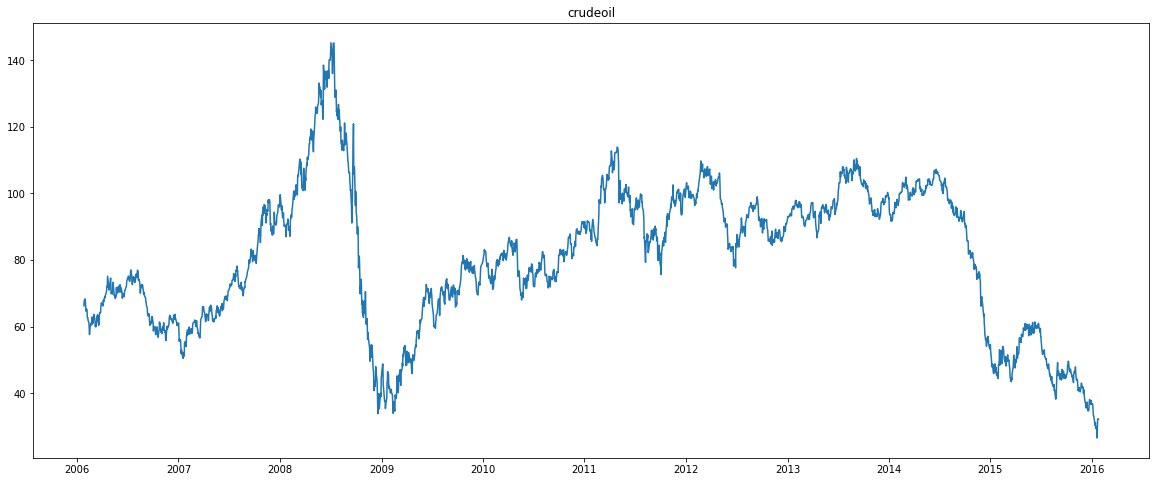

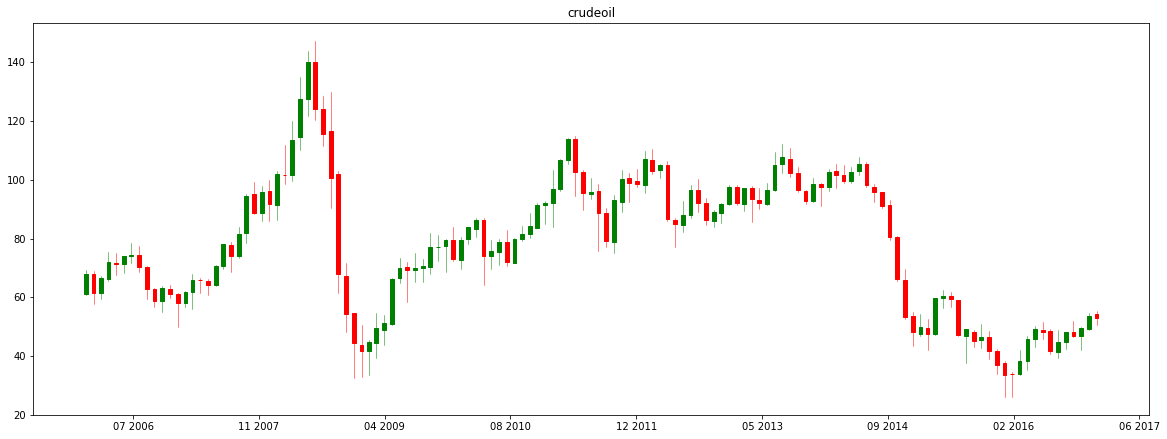

#### us30yeartreasurybonds #####
len: 2155
first 5: [(datetime.datetime(2008, 2, 12, 0, 0), 4.457), (datetime.datetime(2008, 2, 13, 0, 0), 4.54), (datetime.datetime(2008, 2, 14, 0, 0), 4.654), (datetime.datetime(2008, 2, 15, 0, 0), 4.582), (datetime.datetime(2008, 2, 19, 0, 0), 4.665)]
last 5: [(datetime.datetime(2016, 1, 20, 0, 0), 2.758), (datetime.datetime(2016, 1, 21, 0, 0), 2.809), (datetime.datetime(2016, 1, 22, 0, 0), 2.828), (datetime.datetime(2016, 1, 24, 0, 0), 2.827), (datetime.datetime(2016, 1, 25, 0, 0), 2.813)]


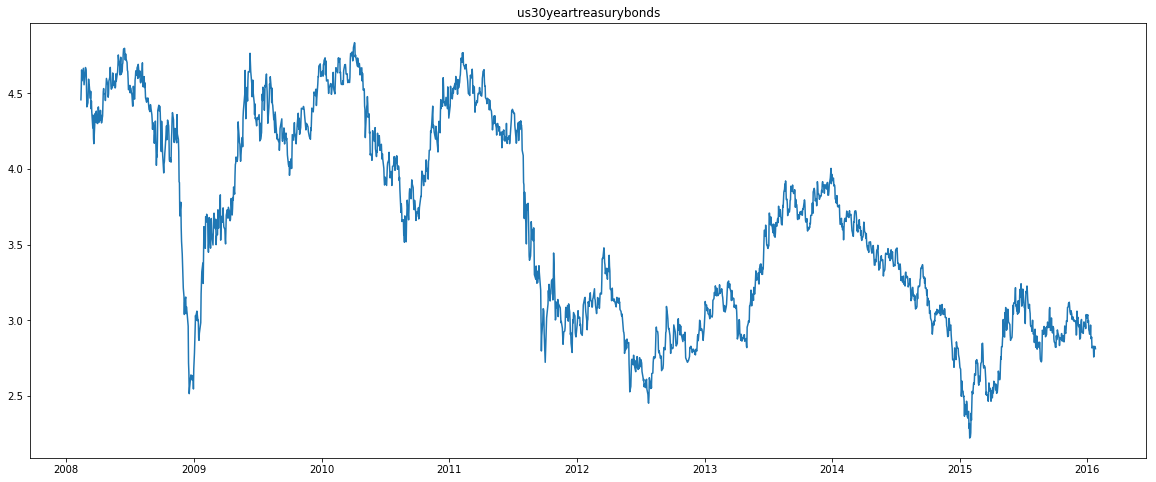

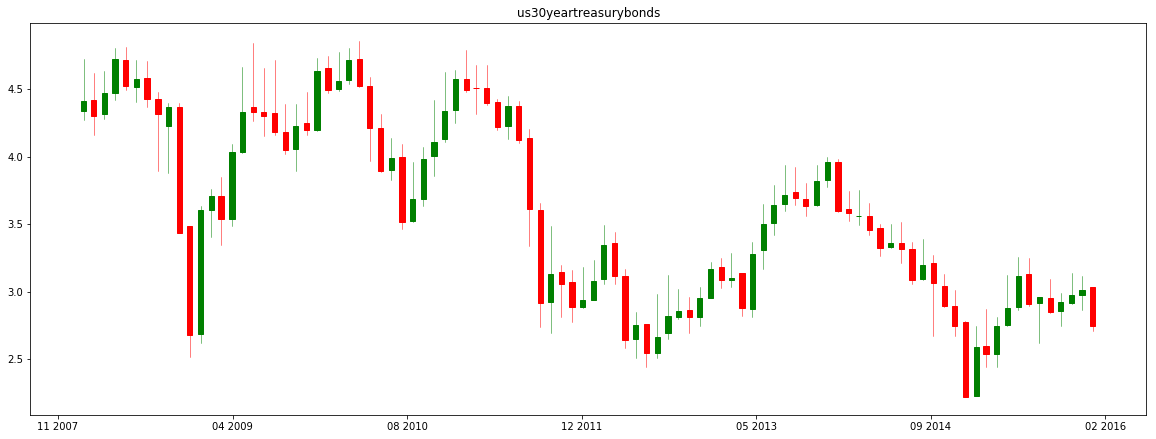

In [16]:
# just print out some useful information and plot two functions
for i in range(len(factors1)):
    print("####", factor1_files[i].split(".", 1)[0] ,"#####")
    print("len:", len(factors1[i]))
    print("first 5:", factors1[i][:5])
    print("last 5:", factors1[i][-5:])
    plot_factor(factors1[i], factor1_files[i].split(".", 1)[0])
    plot_candlestick(factors1_month[i], factor1_files[i].split(".", 1)[0])

**COMMENT**<br>
First of all, we have printed the total number of entries, the first and the last 5 tuples for each factor. In fact, data are ordered, and we are interested in checking the time range (how many years...) to which those data belong to. Moreover, we have also produced two plots for each factor, in order to visualize the trends and the history for each of them and to evidence some usuful information: we have plotted the price/year function and a "candle stick". In the case of the candle stick we have used the monthly dataset, to allow a better visualization of the "candles"; a daily plot would have been a mess. In this way we pay a loss in the precision, as we will consider aggregated data, but the final chard is much more clear and clean.

A candlestick is a chart very used in practice in the finance world that displays the high, low, opening and closing prices of a security for a specific period. The wide part of the candlestick is called the "real body" and tells investors whether the closing price was higher or lower than the opening price. Red indicates that the stock closed lower and green indicates that the stock closed higher.
The candlestick's shadows show the day's high and low and how they compare to the open and close. A candlestick's shape varies based on the relationship between the day's high, low, opening and closing prices.
Candlesticks reflect the impact of investor sentiment on security prices and are used by technical analysts to determine when to enter and exit trades.
Long green candlesticks indicate there is strong buying pressure; this typically indicates price is bullish, however, they should be looked at in the context of the market structure as opposed to individually. For example, a long green candle is likely to have more significance if it forms at a major price support level. Long red candlesticks indicate there is significant selling pressure. This suggests the price is bearish.

Looking at the obtained results, the first thing to notice is that the factor data we are working with differs in size and refers to different time periods (range of years). In fact for the 'crudeoil' we have data (2544 entries) from the 01/26/2006 to the 01/25/2016, while for the 'us treasury bonds' (2155 entries), from the 02/12/2008 to the 01/25/2016; in practice for the first we have additional two years of information.<br>

Another thing to notice is the (possible) existing correlation between the different indexes. In fact, despite the time periods are different, it's possibile to see that in some cases there exist a correlation between the analyzed factors by looking at the trend of the curves plotted in blue. For example it's really evident that at the end of the 2008 there is a strong decrease in the value of both crud oil and trasury bonds. This is probably related to the serious financial crisis of 2008-2009. In ths same way, we can find also other similarities on the trends of both the factors: for example between 2010 and 2011, in both case it's registered a little decrease during the first months and then a regrowth phase during the second semester; or we can see a similar trend also during the 2014 where it's evident a decreasing phase in both the plots. However, the general trend seems to be quite different between the two considered factors, so it's highly expectable that there is a low correlation among them.

It is also interesting to take a look at the candle stick, which obvisouly has a "mirrored" trend of the normal function. It gives a very easy and immediate representation of the factor's behaviour by which it's possibile to see the increasing and decreasing phases associated to the plot. It could be also interesting to use this kind of chart in case of a focused day to day analisys in a given month.

#### Question 4.2
<div class="alert alert-info">
Write a function named `readYahooHistory` to parse data from yahoo.com based on its format, as described in Section 5.3.  
<ul></ul>
Print the first 5 entries of the first factor (namely GSPC). Comment the time range of the second batch of data we use in our Notebook.  
<ul></ul>

Note that we are only interested in the date and price of stocks.
</div>

<div class="label label-danger">NOTE</div> The datetime format now is in a different format than the previous one.

<div class="label label-success">HINT</div> Use a terminal (or put the bash commands inline in your Notebook) to list filenames in your local working directory to find and have a look at your local files.

In [17]:
# read data from local disk
def readYahooHistory(fname):
    def process_line(line):
        cols = line.split(',')
        date = datetime.strptime(cols[0], "%Y-%m-%d")
        value = float(cols[4])
        return (date, value)
    
    with open(fname) as f:
        content_w_header = f.readlines()
        # remove the first line 
        # and reverse lines to sort the data by date, in ascending order
        content = content_w_header[:0:-1]
        return list(map(process_line , content))

In [18]:
factor2_files = ['GSPC.csv', 'IXIC.csv']
factor2_files_map = map(lambda fn: factors_folder + fn, factor2_files)
factors2 = [readYahooHistory(f) for f in factor2_files_map]

print(factors2[0][:5])

[(datetime.datetime(1950, 1, 3, 0, 0), 16.66), (datetime.datetime(1950, 1, 4, 0, 0), 16.85), (datetime.datetime(1950, 1, 5, 0, 0), 16.93), (datetime.datetime(1950, 1, 6, 0, 0), 16.98), (datetime.datetime(1950, 1, 9, 0, 0), 17.08)]


In [19]:
factor2_files_month = ['GSPC_monthly.tsv', 'IXIC_monthly.tsv']
factor2_files_map_month = map(lambda fn: factors_folder + fn, factor2_files_month)
factors2_month = [readInvestingDotComMonthlyHistory(f, "\t") for f in factor2_files_map_month]

print(factors2_month[0][0:5])

[(731306.0, 848.18, 916.92, 924.24, 847.85, 0.0, 8.1), (731336.0, 916.92, 963.59, 965.38, 902.83, 0.0, 5.09), (731367.0, 963.59, 974.5, 1015.33, 963.59, 0.0, 1.13), (731397.0, 974.5, 990.31, 1015.41, 962.1, 0.0, 1.62), (731428.0, 990.31, 1008.01, 1011.01, 960.84, 0.0, 1.79)]


#### GSPC #####
len: 16621
first 5: [(datetime.datetime(1950, 1, 3, 0, 0), 16.66), (datetime.datetime(1950, 1, 4, 0, 0), 16.85), (datetime.datetime(1950, 1, 5, 0, 0), 16.93), (datetime.datetime(1950, 1, 6, 0, 0), 16.98), (datetime.datetime(1950, 1, 9, 0, 0), 17.08)]
last 5: [(datetime.datetime(2016, 1, 15, 0, 0), 1880.329956), (datetime.datetime(2016, 1, 19, 0, 0), 1881.329956), (datetime.datetime(2016, 1, 20, 0, 0), 1859.329956), (datetime.datetime(2016, 1, 21, 0, 0), 1868.98999), (datetime.datetime(2016, 1, 22, 0, 0), 1906.900024)]


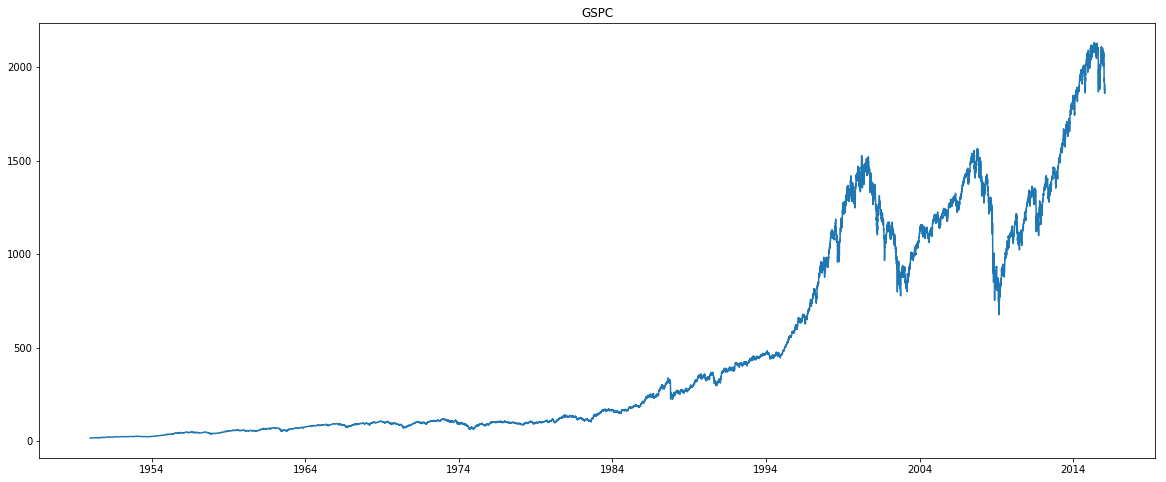

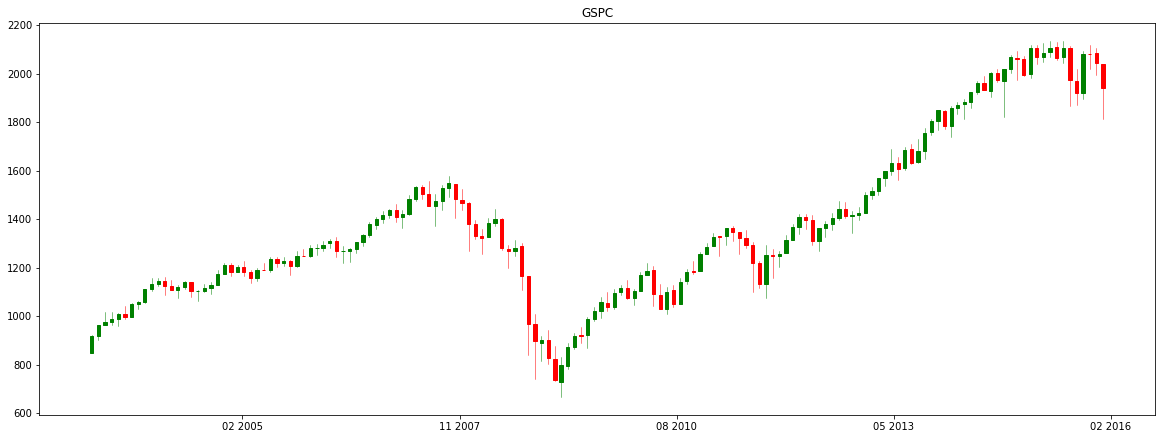

#### IXIC #####
len: 11340
first 5: [(datetime.datetime(1971, 2, 5, 0, 0), 100.0), (datetime.datetime(1971, 2, 8, 0, 0), 100.839996), (datetime.datetime(1971, 2, 9, 0, 0), 100.760002), (datetime.datetime(1971, 2, 10, 0, 0), 100.690002), (datetime.datetime(1971, 2, 11, 0, 0), 101.449997)]
last 5: [(datetime.datetime(2016, 1, 15, 0, 0), 4488.419922), (datetime.datetime(2016, 1, 19, 0, 0), 4476.950195), (datetime.datetime(2016, 1, 20, 0, 0), 4471.689941), (datetime.datetime(2016, 1, 21, 0, 0), 4472.060059), (datetime.datetime(2016, 1, 22, 0, 0), 4591.180176)]


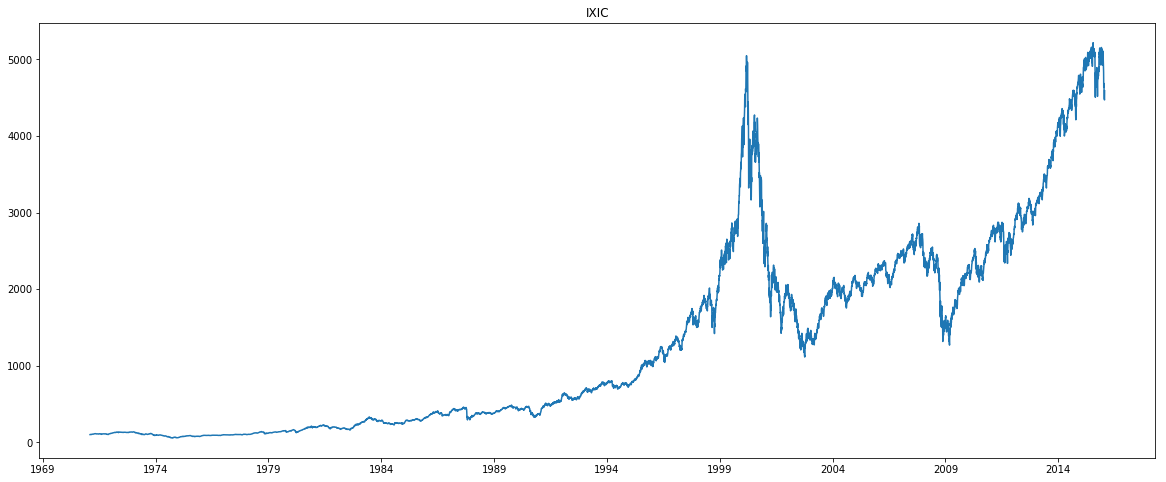

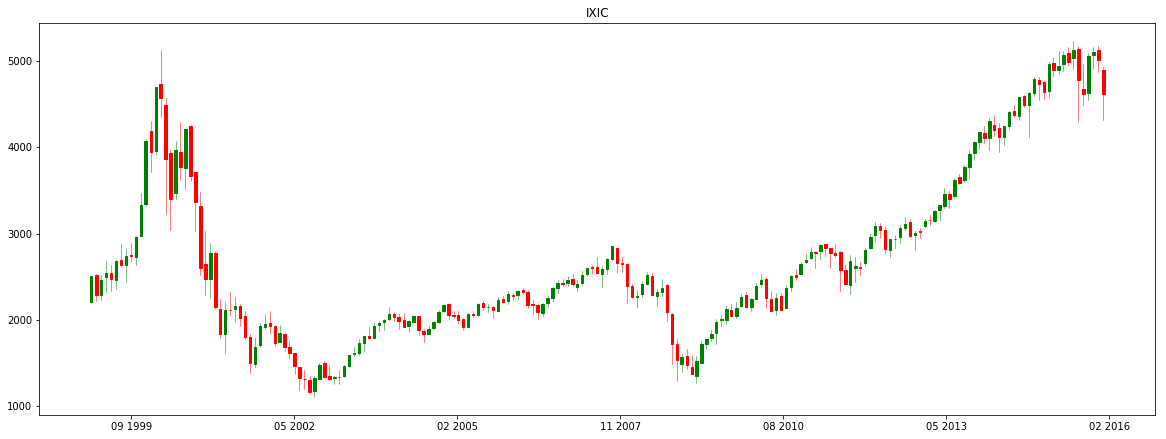

In [20]:
for i in range(len(factors2)):
    print("####", factor2_files[i].split(".", 1)[0] ,"#####")
    print("len:", len(factors2[i]))
    print("first 5:", factors2[i][:5])
    print("last 5:", factors2[i][-5:])
    plot_factor(factors2[i], factor2_files[i].split(".", 1)[0])
    plot_candlestick(factors2_month[i], factor2_files[i].split(".", 1)[0])

**COMMENT**<br>
In the same way, we have analyzed the data coming from Yahoo!, in particular those regarding the factors GSPC (16621 entries) and IXIC (11340 entries). Also in this case we have produced a set of interesting prints and the two plots described above. In this case, however, we did not used the whole monthly dataset for the candle stick, in fact, here, the set of available information is much bigger if compared to those taken from 'investing.com': here we have data starting from 1950 to 2016 for the GSPC and from the 1971 to 2016 for the IXIC. So, in order to allow a clean visualization of the candles, in this case we have decided to analyze only the most "relevant" and recent informations, so those after 1999.<br>

It is in fact interesting to notice (by looking at the standard function plot) that there has been a slow and soft growth in both the cases during the first years, with a very decise and net increase after the 1999.

Here the correlation between the different indexes appears to be much more evident; we can see exactly the same "general" trend, with the pics at the same moment. For example around the year 2000 it's possibile to notice the same trend as already said above. It could be also interesting to compare all the considered factors among each others, but in this case it appears quite difficult to notice similarities between the two from Yahoo and the two from investing.com as we are using different "scales" (there is an huge difference in the number of considered years and the common portion is quite small). We will go more into the details about the correlation later on.

Now, the data structure `factors2` is again list, containing data that pertains to the next two (out of a total of four) factors that influence the market, as obtained by Yahoo!. Each element in the list is a tuple, containing some sort of timestamp, and the value of one of the two factors discussed above. Visually, `factors2` looks like this:

| 0 (GSPC) | 1 (IXIC)|
| --- | --- |
| time_stamp, value | time_stamp, value |
| ... | ... |
| time_stamp, value | time_stamp, value |
| ... | ... |


### Stock data pre-processing

Next, we prepare the data for the instruments we consider in this Notebook (i.e., the stocks we want to invest in). 

#### Question 4.3

<div class="alert alert-info">
In this Notebook, we assume that we want to invest on the first 35 stocks out of the total 3000 stocks present in our datasets.

<ul></ul>

Load and prepare all the data for the considered instruments (the first 35 stocks) which have historical information for more than 5 years. This means that all instruments with less than 5 years of history should be removed.

</div>

<div class="label label-success">HINT</div> we suggest to open a terminal window (not on your local machine, but the Notebook terminal that you can find on the Jupyter dashboard) and visually check the contents of the directories holding our dataset, if you didn't do this before! Have a look at how stock data is organized!

In [21]:
from os import listdir
from os.path import isfile, join

stock_folder = base_folder + 'stocks'

def process_stock_file(fname):
    try:
        def process_line(line):
            cols = line.split(',')
            date = datetime.strptime(cols[0], "%Y-%m-%d")
            value = float(cols[4])
            return (date, value)

        with open(fname) as f:
            content_w_header = f.readlines()
            # remove the first line 
            # and reverse lines to sort the data by date, in ascending order
            content = list(reversed(content_w_header[1:]))
            return list(map(process_line , content))
    except Exception as e:
        raise e
        return None



# select path of all stock data files in "stock_folder"
files = [join(stock_folder, f) for f in listdir(stock_folder) if isfile(join(stock_folder, f))]

# assume that we invest only the first 35 stocks (for faster computation)
files = files[:35]

# read each line in each file, convert it into the format: (date, value)
rawStocks = [process_stock_file(f) for f in files]

# select only instruments which have more than 5 years of history
# Note: the number of business days in a year is 260
number_of_years = 5
rawStocks = list(filter(lambda instrument: len(instrument) > (260*number_of_years) , rawStocks))

# For testing, print the first 5 entry of the first stock
print(rawStocks[0][:5])

[(datetime.datetime(1997, 8, 14, 0, 0), 39.0), (datetime.datetime(1997, 8, 15, 0, 0), 42.0), (datetime.datetime(1997, 8, 18, 0, 0), 48.5), (datetime.datetime(1997, 8, 19, 0, 0), 48.0), (datetime.datetime(1997, 8, 20, 0, 0), 48.0)]


### Time alignment for our data
Different types of instruments may trade on different days, or the data may have missing values for other reasons, so it is important to make sure that our different histories align. First, we need to trim all of our time series to the same region in time. Then, we need to fill in missing values. To deal with time series that have missing values at the start and end dates in the time region, we simply fill in those dates with nearby values in the time region.

#### Question 4.4
<div class="alert alert-info">
Assume that we only focus on the data from 23/01/2009 to 23/01/2014. Write a function named `trimToRegion` to select only the records in that time interval. 

<ul></ul>

**Requirements**: after processing, each instrument $i$ has a list of records: $[r_0, r_2,...,r_{m_i}]$ such that $r_0$ and $r_{m_i}$ are assigned, respectively, the first and the last values corresponding to the extremes of the given time interval. For example: $r_0$ should contain the value at date 23/01/2009.
</div>

In [22]:
# note that the data of crude oil and treasury is only available starting from 26/01/2006 
start = datetime(year=2009, month=1, day=23)
end = datetime(year=2014, month=1, day=23)

def trimToRegion(history, start, end):
    def isInTimeRegion(entry):
        (date, value) = entry
        return date >= start and date <= end

    # only select entries which are in the time region
    trimmed = list(filter(isInTimeRegion, history))
    
    # if the data has incorrect time boundaries, add time boundaries
    if trimmed[0][0] != start:
        trimmed.insert(0, (start, trimmed[0][1]))
    if trimmed[-1][0] != end:
        trimmed.append((end, trimmed[-1][1]))
    return trimmed
    
# test our function
trimmedStock0  = trimToRegion(rawStocks[0], start, end)
# the first 5 records of stock 0
print(trimmedStock0[:5])
# the last 5 records of stock 0
print(trimmedStock0[-5:])

assert(trimmedStock0[0][0] == start), "the first record must contain the price in the first day of time interval"
assert(trimmedStock0[-1][0] == end), "the last record must contain the price in the last day of time interval"

[(datetime.datetime(2009, 1, 23, 0, 0), 19.549999), (datetime.datetime(2009, 1, 26, 0, 0), 19.809999), (datetime.datetime(2009, 1, 27, 0, 0), 20.09), (datetime.datetime(2009, 1, 28, 0, 0), 21.620001), (datetime.datetime(2009, 1, 29, 0, 0), 19.82)]
[(datetime.datetime(2014, 1, 16, 0, 0), 37.400002), (datetime.datetime(2014, 1, 17, 0, 0), 37.380001), (datetime.datetime(2014, 1, 21, 0, 0), 37.82), (datetime.datetime(2014, 1, 22, 0, 0), 37.68), (datetime.datetime(2014, 1, 23, 0, 0), 36.77)]


### Dealing with missing values
We expect that we have the price of instruments and factors **in each business day**. Unfortunately, there are many missing values in our data: this means that we miss data for some days, e.g. we have data for the Monday of a certain week, but not for the subsequent Tuesday. So, we need a function that helps filling these missing values.

Next, we provide to you the function to fill missing value: read it carefully!

In [23]:
def fillInHistory(history, start, end):
    curr = history
    filled = []
    idx = 0
    curDate = start
    numEntries = len(history)
    while curDate < end:
        
        # if the next entry is in the same day
        # or the next entry is at the weekend
        # but the curDate has already skipped it and moved to the next monday
        # (only in that case, curr[idx + 1][0] < curDate )
        # then move to the next entry
        while idx + 1 < numEntries and curr[idx + 1][0] <= curDate:
            idx +=1

        # only add the last value of instrument in a single day
        # check curDate is weekday or not
        # 0: Monday -> 5: Saturday, 6: Sunday
        if curDate.weekday() < 5:
            
            filled.append((curDate, curr[idx][1]))
            # move to the next business day
            curDate += timedelta(days=1)
        
        # skip the weekends
        elif curDate.weekday() >= 5:
            # if curDate is Sat, skip 2 days, otherwise, skip 1 day
            curDate += timedelta(days=(7-curDate.weekday()))

    return filled

#### Question 4.5
<div class="alert alert-info">
Trim data of stocks and factors into the given time interval.
</div>

In [24]:
# trim into a specific time region
# and fill up the missing values
stocks = list(map(lambda stock: \
            fillInHistory(
                trimToRegion(stock, start, end), 
            start, end), 
        rawStocks))



# merge two factors, trim each factor into a time region
# and fill up the missing values
allfactors = factors1 + factors2
factors = list(map(lambda factor: \
            fillInHistory(
                trimToRegion(factor, start, end), 
            start, end), 
        allfactors))
            
# test our code
print("the first 5 records of stock 0:", stocks[0][:5], "\n")
print("the last 5 records of stock 0:", stocks[0][-5:], "\n")
print("the first 5 records of factor 0:", factors[0][:5], "\n")
print("the first 5 records of factor 0:", factors[0][-5:], "\n")

the first 5 records of stock 0: [(datetime.datetime(2009, 1, 23, 0, 0), 19.549999), (datetime.datetime(2009, 1, 26, 0, 0), 19.809999), (datetime.datetime(2009, 1, 27, 0, 0), 20.09), (datetime.datetime(2009, 1, 28, 0, 0), 21.620001), (datetime.datetime(2009, 1, 29, 0, 0), 19.82)] 

the last 5 records of stock 0: [(datetime.datetime(2014, 1, 16, 0, 0), 37.400002), (datetime.datetime(2014, 1, 17, 0, 0), 37.380001), (datetime.datetime(2014, 1, 20, 0, 0), 37.380001), (datetime.datetime(2014, 1, 21, 0, 0), 37.82), (datetime.datetime(2014, 1, 22, 0, 0), 37.68)] 

the first 5 records of factor 0: [(datetime.datetime(2009, 1, 23, 0, 0), 46.47), (datetime.datetime(2009, 1, 26, 0, 0), 45.73), (datetime.datetime(2009, 1, 27, 0, 0), 41.58), (datetime.datetime(2009, 1, 28, 0, 0), 42.16), (datetime.datetime(2009, 1, 29, 0, 0), 41.44)] 

the first 5 records of factor 0: [(datetime.datetime(2014, 1, 16, 0, 0), 93.96), (datetime.datetime(2014, 1, 17, 0, 0), 94.37), (datetime.datetime(2014, 1, 20, 0, 0),

Recall that Value at Risk (VaR) deals with **losses over a particular time horizon**. We are not concerned with the absolute prices of instruments, but how those prices **change over** a given period of time. In our project, we will set that length to two weeks: we use the sliding window method to transform time series of prices into an overlapping sequence of price change over two-week intervals.

The figure below illustrates this process. The returns of market factors after each two-week interval is calculated in the very same way.

![](https://dl.dropboxusercontent.com/s/r9ucsicichb6gjh/two-week-time-interval.svg)

In [25]:
def buildWindow(seq, k=2):
    "Returns a sliding window (of width k) over data from iterable data structures"
    "   s -> (s0,s1,...s[k-1]), (s1,s2,...,sk), ...                   "
    it = iter(seq)
    result = tuple(islice(it, k))
    if len(result) == k:
        yield result  
    for elem in it:
        result = result[1:] + (elem,)
        yield result

#### Question 4.6
<div class="alert alert-info">
Compute the returns of the stocks after each two-week time window.
</div>

In [26]:
def calculateReturn(window):
    # return the change of value after two weeks
    return window[-1][1] - window[0][1]

def twoWeekReturns(history):
    # we use 10 instead of 14 to define the window
    # because financial data does not include weekends
    return [calculateReturn(entry) for entry in buildWindow(history, 10)]

stocksReturns = list(map(twoWeekReturns, stocks))
factorsReturns = list(map(twoWeekReturns, factors))

# test our functions
print("the first 5 returns of stock 0:", stocksReturns[0][:5])
print("the last 5 returns of stock 0:", stocksReturns[0][-5:])

the first 5 returns of stock 0: [1.0899999999999999, 0.8700009999999985, 0.2999989999999997, -2.3100019999999972, 0.13999899999999954]
the last 5 returns of stock 0: [-1.3099970000000027, -0.6899990000000003, -0.7999989999999997, 0.27999900000000366, -0.11999899999999997]


Alright! Now we have data that is properly aligned to start the training process: stocks' returns and factors' returns, per time windows of two weeks. Next, we will apply the MCS method.

## 5.5. Summary guidelines to apply the MCS method on the data we prepared
Next, we overview the steps that you have to follow to build a model of your data, and then use Monte Carlo simulations to produce output distributions:

- **Step 1**: Defining the relationship between the market factors and the instrument's returns. This relationship takes the form of a model fitted to historical data.
- **Step 2**: Defining the distributions for the market conditions (particularly, the returns of factors) that are straightforward to sample from. These distributions are fitted to historical data. 
- **Step 3**: Generate the data for each trial of a Monte Carlo run: this amount to generating the random values for market conditions along with these distributions.
- **Step 4**: For each trial, from the above values of market conditions, and using the relationship built in step 1, we calculate the return for each instrument and the total return. We use the returns to define an empirical distribution over losses. This means that, if we run 100 trials and want to estimate the 5% VaR, we would choose it as the loss from the trial with the fifth greatest loss.
- **Step 5**: Evaluating the result

## 5.6. Applying MCS

### Step 1: Defining relationship between market factors and instrument's returns

In our simulation, we will use a simple linear model. By our definition of return, a factor return is a **change** in the value of a market factor **over a particular time period**, e.g. if the value of the S&P 500 moves from 2000 to 2100 over a time interval, its return would be 100.

A vector that contains the return of 4 market factors is called a *market factor vector*. Generally, instead of using this vector as features, we derive a set of features from simple transformation of it. In particular, a vector of 4 values is transformed into a vector of length $m$ by function $F$. In the simplest case $F(v) = v$.

Denote $v_t$ the market factor vector, and $f_t$ the transformed features of $v_t$ at time $t$.

$f_{tj}$ is the value of feature $j$ in $f_t$.

Denote $r_{it}$ the return of instrument $i$ at time $t$ and $c_i$ the [intercept term](http://blog.minitab.com/blog/adventures-in-statistics/regression-analysis-how-to-interpret-the-constant-y-intercept) of instrument $i$.

We will use a simple linear function to calculate $r_{it}$ from $f_t$:

$$
r_{it} = c_i + \sum_{j=1}^{m}{w_{ij}*f_{tj}}
$$

where $w_{ij}$ is the weight of feature $j$ for instrument $i$.

All that above means that given a market factor vector, we have to apply featurization and then use the result as a surrogate for calculating the return of the instruments, using the above linear function.

There are two questions that we should consider: **how we apply featurization to a factor vector?** and **how to pick values for $w_{ij}$?**

**How we apply featurization to a factor vector?**
In fact, the instruments' returns may be non-linear functions of the factor returns. So, we should not use factor returns as features in the above linear function. Instead, we transform them into a set of features with different size. In this Notebook, we can include some additional features in our model that we derive from non-linear transformations of the factor returns. We will try adding two more features for each factor return: its square and its square root values. So, we can still assume that our model is a linear model in the sense that the response variable is a linear function of the new features. *Note that the particular feature transformation described here is meant to be an illustrative example of some of the options that are available: it shouldn't be considered as the state of the art in predictive financial modeling!!*.

**How to pick values for $w_{ij}$?**

For all the market factor vectors in our historical data, we transform them to feature vectors. Now, we have feature vectors in many two-week intervals and the corresponding instrument's returns in these intervals. We can use Ordinary Least Square (OLS) regression model to estimate the weights for each instrument such that our linear function can fit to the data. The parameters for OLS function are:

- `x`: The collection of columns where **each column** is the value of **a feature** in many two-week interval
- `y`: The return of an instrument in the corresponding time interval of x.

The figure below shows the basic idea of the process to build a statistical model for predicting the returns of stock X.

![](https://dl.dropboxusercontent.com/s/kbjtwmnr4w31uev/process-build-model3.svg)


### Question 5
#### Question 5.1

<div class="alert alert-info">
Currently, our data is in form of:  

$$
factorsReturns=
\begin{bmatrix}
 r_{00} & r_{01} & r_{02} & ... & r_{0k} \\
 r_{10} & r_{11} & r_{12} & ... & r_{1k} \\
 ... & ... & ... & ... & ... \\
 r_{n0} & r_{n1} & r_{n2} & ... & r_{nk}\\
\end{bmatrix}
$$

<ul></ul>

$$
stocksReturns=
\begin{bmatrix}
 s_{00} & s_{01} & s_{02} & ... & s_{0k} \\
 s_{10} & s_{11} & s_{12} & ... & s_{1k} \\
 ... & ... & ... & ... & ... \\
 s_{n0} & s_{n1} & s_{n2} & ... & s_{nk}\\
\end{bmatrix}
$$

<ul></ul>

Where, $r_{ij}$ is the return of factor $i^{th}$ in time window $j^{th}$, $k$ is the number of time windows, and $n$ is the number of factors. A similar definition goes for $s_{ij}$.

<ul></ul>

In order to use OLS, the parameter must be in form of:

<ul></ul>

$$
x=factorsReturns^T =
\begin{bmatrix}
 r_{00} & r_{10} & ... & r_{n0} \\
 r_{01} & r_{11} & ... & r_{n1} \\
 r_{02} & r_{12} & ... & r_{n2}\\
 ... & ... & ... & ... \\
 r_{0k} & r_{1k} & ... & r_{nk}\\
\end{bmatrix}
$$

<ul></ul>

Whereas, $y$ can be any row in `stocksReturns`.

<ul></ul>

So, we need a function to transpose a matrix. Write a function named `transpose` to do just that.
</div>

In [27]:
def transpose(matrix):
    numpy_matrix = np.matrix(matrix)
    return np.transpose(numpy_matrix).tolist()
    
# test function
assert (transpose([[1,2,3], [4,5,6], [7,8,9]]) == [[1, 4, 7], [2, 5, 8], [3, 6, 9]]), "Function transpose runs incorrectly"

#### Question 5.2
<div class="alert alert-info">
Write a function named `featurize` that takes a list factor's returns $[x_1, x_2,...,x_k]$ and transform it into a new list of features $[u_1,u_2,..,u_k, v_1, v_2,..,v_k, x_1,x_2,...,x_k]$.

<ul></ul>

Where,  


$u_i$ = $\left\{
	\begin{array}{ll}
		x_i^2 & \mbox{if } x_i \geq 0 \\
		-x_i^2 & \mbox{if } x_i < 0
	\end{array}
\right.
$

<ul></ul>

and  

$v_i$ = $\left\{
	\begin{array}{ll}
		\sqrt{x_i} & \mbox{if } x_i \geq 0 \\
		-\sqrt{x_i} & \mbox{if } x_i < 0
	\end{array}
\right.
$  

</div>

In [28]:
import math

In [29]:
# Increase the dimension of the feature matrix by adding their square root and square values.
# The final dimension will be 3 times bigger than the initial one
def featurize(factorReturns):
    squaredReturns = [x**2 if x >= 0 else -(x**2) for x in factorReturns]
    squareRootedReturns = [math.sqrt(x) if x >= 0 else -math.sqrt(-x) for x in factorReturns]
    # concat new features
    return squaredReturns + squareRootedReturns + factorReturns

# test our function
assert (featurize([4, -9, 25]) == [16, -81, 625, 2, -3, 5, 4, -9, 25]), "Function runs incorrectly"

#### Question 5.3
<div class="alert alert-info">
Using OLS, estimate the weights for each feature on each stock. What is the shape of `weights` (size of each dimension)?  

Explain it.
</div>

In [30]:
def estimateParams(y, x):
    return sm.OLS(y, x).fit().params

# transpose factorsReturns
factorMat = transpose(factorsReturns)

# featurize each row of factorMat
factorFeatures = list(map(featurize, factorMat))

# OLS require parameter is a numpy array
factor_columns = np.array(factorFeatures)

#add a constant - the intercept term for each instrument i.
factor_columns = sm.add_constant(factor_columns, prepend=True)

# estimate weights
weights = [estimateParams(stockReturns, factor_columns) for stockReturns in stocksReturns]

print('[weights dimensions]  Rows:', len(weights), ' Columns:', len(weights[0]))
print("weights:", weights)

[weights dimensions]  Rows: 29  Columns: 13
weights: [array([ 3.20898766e-03, -2.45485295e-03, -6.25853573e+00,  2.02191163e-04,
       -4.27891642e-05,  3.68096310e-02, -1.03671044e+00,  2.69314316e-02,
       -6.26576798e-02,  3.19971474e-06,  3.63833062e+00,  3.38909501e-03,
        1.11211759e-02]), array([-8.94744122e-02,  2.44886213e-03, -2.43299006e+00,  2.91040561e-04,
       -5.42223122e-05,  1.91384440e-01,  7.04395045e-01,  1.10048307e-01,
       -4.83945095e-02, -1.00716645e-01,  7.50871857e-01, -3.81844287e-02,
        3.12688061e-02]), array([-1.43645330e-02,  2.46869212e-03, -1.94365640e+00,  5.55846589e-05,
       -1.27737863e-05,  3.86113786e-02, -2.05334039e-01,  1.90255397e-03,
       -2.24765287e-03, -4.80912323e-02,  9.70523887e-01, -1.50022520e-03,
        2.52739843e-03]), array([ 4.63892014e-02, -3.41977168e-04, -1.52753597e+00,  7.08864363e-06,
       -3.12310764e-06,  1.31500668e-02,  1.28905126e-01,  5.86038045e-02,
       -5.74148252e-02,  3.65335888e-03, -3

**COMMENT**<br>
The shape of the weights matrix is (29, 13). This is because we have one row for each stock, but there are 29 of them instead of 35 that we specified previously because we wanted only to analyze the stocks that have more than 5 years of data. For each stock there are 13 values that are the results of the product of market factor returns featurized by the stock returns (12 values) and the intercept term.

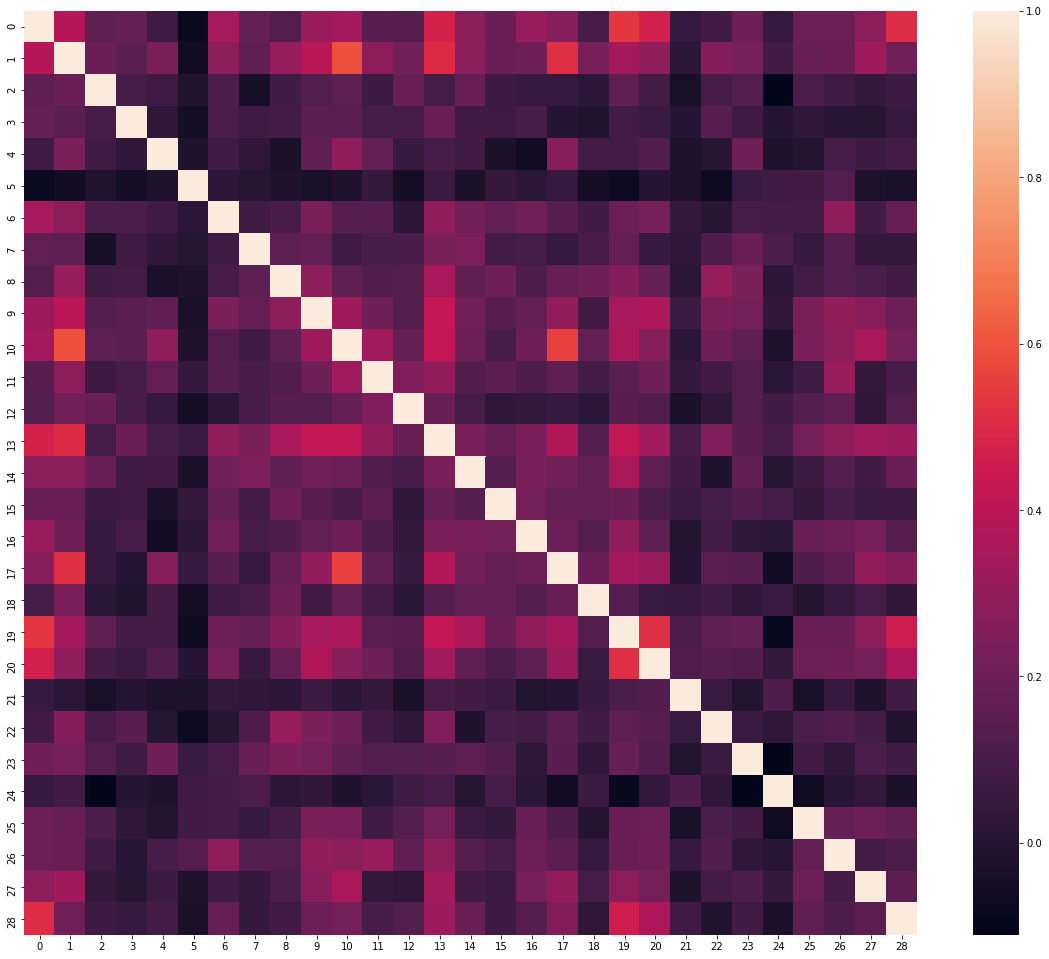

In [31]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(20,17))         # Sample figsize in inches
correlation = np.corrcoef(stocksReturns)
#create a heat map to represent the correlations among all stocks
sns.heatmap(correlation, ax=ax)

**COMMENT**<br>
In this case we have tried to analyze the correlation between different stocks, to eventually undercover possibile relations between different ones.<br>
In this case, as said above, we are analyzing 29 different stocks, so we have plotted this 29x29 heatmap that graphically represents the correlations. An heatmap, in fact, is very useful to represent this concept as we can visualize the correlation with the colors: considering the chosen colormap, a darker tonality indicates a lower correlation, while a brighter one indicates an higher correlation.<br>
So, by looking at the obtained results, we can see that generally there is a low correlation between the stocks, as we can see a lot of black and violet squares (so the correlation factor is less than 0.2 in most of the cases). But there is also some brighter case, for example between the stocks 2 and 10, where it seems to be around ~ 0.6 - 0.7

In [32]:
def mean_square(a, b):
    # produce a list of squared errors
    se = [(a1 - b1)**2 for a1, b1 in zip(a, b)]
    # return mean square
    return np.mean(se)

def predict(factors, weights): 
    l = [f*w for f, w in zip(factors, weights)]
    return sum(l)

listOfMeanSquares = []

for i, w in enumerate(weights):
    predictions = map(lambda f: predict(f, w), factor_columns) 
    me = mean_square(predictions, stocksReturns[i])
    listOfMeanSquares.append(me)

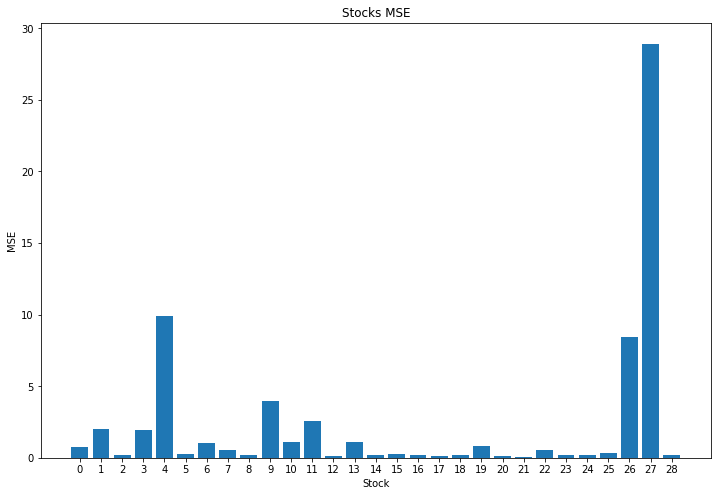

In [33]:
#plot the mean squared error for each stock we are investing in
plt.figure(figsize=(12,8))
plt.title("Stocks MSE")
x = np.arange(len(listOfMeanSquares))
plt.bar(x, listOfMeanSquares)
plt.xlabel("Stock")
plt.ylabel("MSE")
plt.xticks(x)
plt.show()

**COMMENT**<br>
Here we wanted to analyze the MSE for the resulting stocks in order to check the overall "performances" of our model. From the obtained results it's possibile to see that in general the MSE is quite low, with only three values among twenty-nine above a MSE of 5.<br>
As a result we can conclude that our model is quite good.

### Step 2: Defining the distributions for the market conditions
Since we cannot define the distributions for the market factors directly, we can only approximate their distribution.
The best way to do that, is plotting their value. However, these values may fluctuate quite a lot. 

Next, we show how to use the Kernel density estimation (KDE) technique to approximate such distributions. In brief, kernel density estimation is a way of smoothing out a histogram: this is achieved by assigning (or centering) a probability distribution (usually a normal distribution) to each data point, and then summing. So, a set of two-week-return samples would result in a large number of "super-imposed" normal distributions, each with a different mean. 

To estimate the probability density at a given point, KDE evaluates the PDFs of all the normal distributions at that point and takes their average. The smoothness of a kernel density plot depends on its *bandwidth*, and the standard deviation of each of the normal distributions. For a brief introduction on KDE, please refer to this [link](https://en.wikipedia.org/wiki/Kernel_density_estimation).

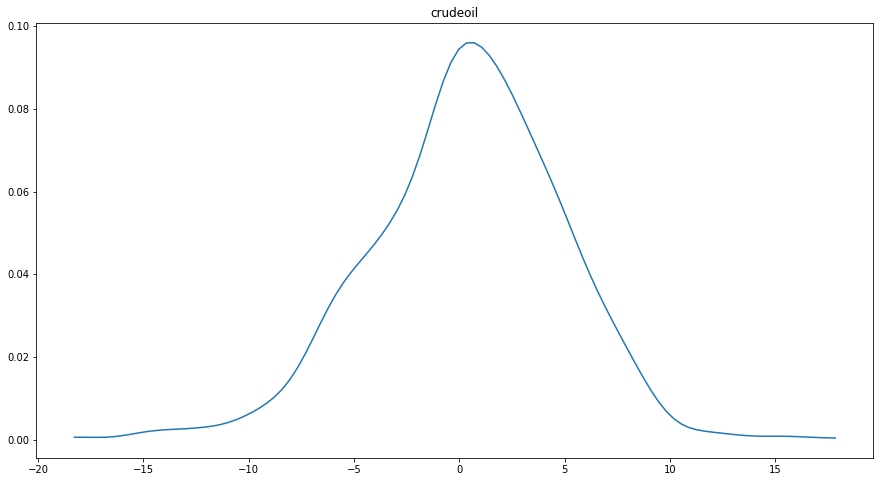

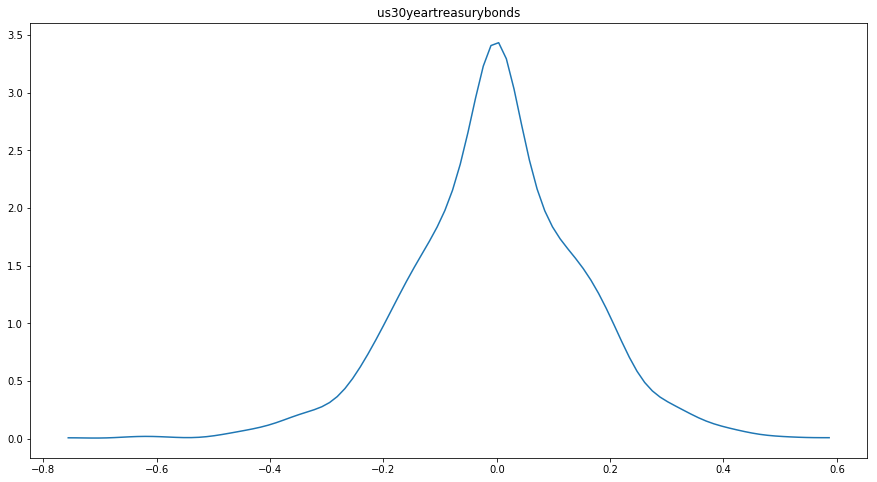

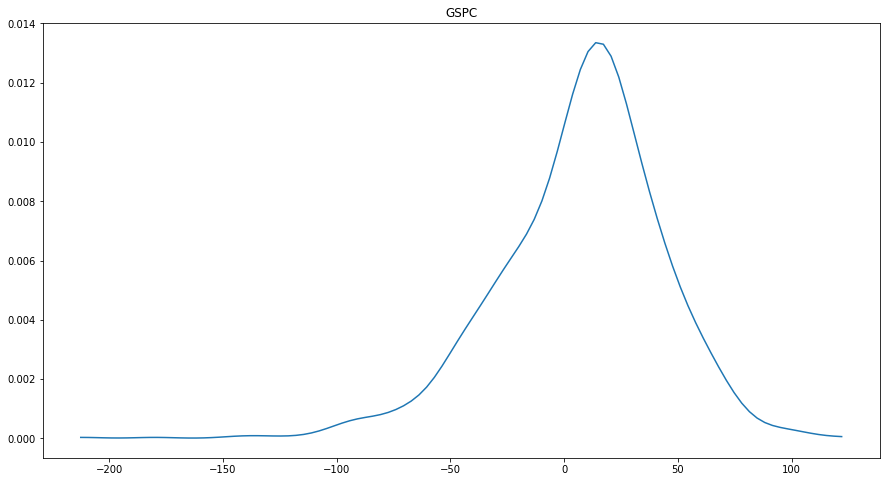

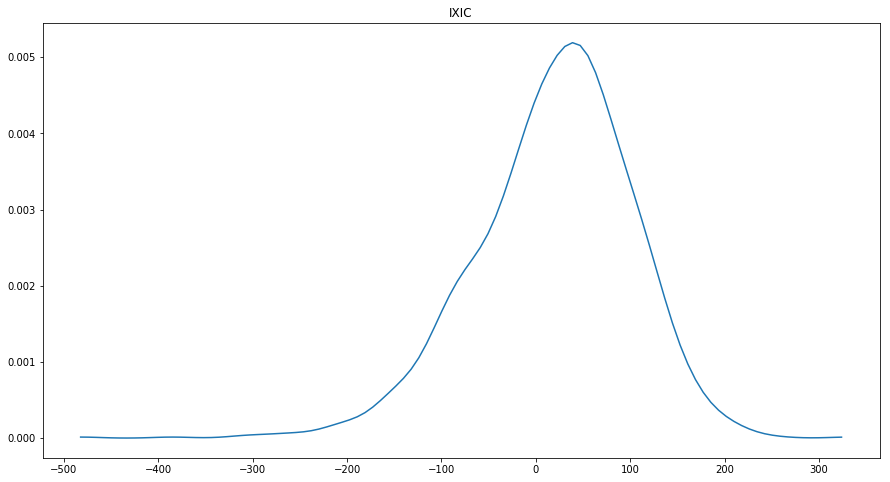

In [34]:
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from statsmodels.nonparametric.kde import KDEUnivariate
import matplotlib.pyplot as plt
import scipy

def plotDistribution(samples, title=None):
    vmin = min(samples)
    vmax = max(samples)
    stddev = np.std(samples)
    
    domain = np.arange(vmin, vmax, (vmax-vmin)/100)
    
    # a simple heuristic to select bandwidth
    bandwidth = 1.06 * stddev * pow(len(samples), -.2)
    
    # estimate density
    kde = KDEUnivariate(samples)
    kde.fit(bw=bandwidth)
    density = kde.evaluate(domain)
    
    # plot
    plt.figure(figsize=(15,8))
    if title: plt.title(title)
    plt.plot(domain, density)
    plt.show()

plotDistribution(factorsReturns[0], factor1_files[0].split(".")[0])
plotDistribution(factorsReturns[1], factor1_files[1].split(".")[0])
plotDistribution(factorsReturns[2], factor2_files[0].split(".")[0])
plotDistribution(factorsReturns[3], factor2_files[1].split(".")[0])

For the sake of simplicity, we can say that our smoothed versions of the returns of each factor can be represented quite well by a normal distribution. Of course, more exotic distributions, perhaps with fatter tails, could fit more closely the data, but it is outside the scope of this Notebook to proceed in this way.

Now, the simplest way to sample factors returns is to use a normal distribution for each of the factors, and sample from these distributions independently. However, this approach ignores the fact that market factors are often correlated. For example, when the price of crude oil is down, the price of treasury bonds is down too. We can check our data to verify about the correlation.

### Question 6

#### Question 6.1
<div class="alert alert-info">

Calculate the correlation between market factors and explain the result.

</div>

<div class="label label-success">HINT</div> function `np.corrcoef` might be useful.

In [35]:
correlation = np.corrcoef(factorsReturns)
print("Row 0: Crude Oil")
print("Row 1: US Treasury Bond")
print("Row 2: GSPC")
print("Row 3: IXIC")
print("Correlations:\n", correlation)

Row 0: Crude Oil
Row 1: US Treasury Bond
Row 2: GSPC
Row 3: IXIC
Correlations:
 [[1.         0.38788549 0.47411609 0.45841194]
 [0.38788549 1.         0.58447669 0.58306416]
 [0.47411609 0.58447669 1.         0.95227596]
 [0.45841194 0.58306416 0.95227596 1.        ]]


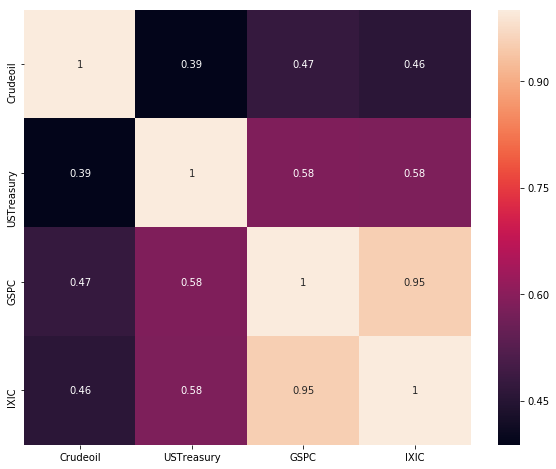

In [36]:
factor_names = ['Crudeoil', 'USTreasury', 'GSPC', 'IXIC']
fig, ax = plt.subplots(figsize=(10,8))         # Sample figsize in inches

# create a heat map to reresent the correlation among all market factors
sns.heatmap(correlation, xticklabels=factor_names, yticklabels=factor_names, annot=True, ax = ax)

**COMMENT**<br>
As we have already mentioned above, we have noticed a certain correlation among the analyzed factors, in particular among the GSPC and IXIC. This is confirmed in a manner that is readily evident in the correlation matrix above and in particular within the plotted heatmap. In fact, here it is clear that we have a very high correlation (0.95) between GSPC and IXIC, while we have a lower correlation between Crude Oil and US Treasury bond.<br>
This high correlation (IXIC-GSPC) was somehow expected due to the nature of the two indexes; those are in fact collections of the most important indexes: the GSPC gathers together all the indexes related to the companies with the highest capitalization factor, while the IXIC gathers together all the indexes of the most important tech companies.<br>
The Nasdaq Composite Index is the market capitalization-weighted index of approximately 3,000 common equities listed on the Nasdaq stock exchange. The types of securities in the index include American depositary receipts, common stocks, real estate investment trusts (REITs) and tracking stocks, as well as limited partnership interests. The index includes all Nasdaq-listed stocks that are not derivatives, preferred shares, funds, exchange-traded funds (ETFs) or debenture securities. Standard and Poor's 500 Index is a capitalization-weighted index of 500 stocks. The index is designed to measure performance of the broad domestic economy through changes in the aggregate market value of 500 stocks representing all major industries.<br>
Due to this reason we were expecting this high correlation as those "factors" most of the times are correlated (tech companies often are the one with the highest capitalization value).

Moreover, in this case it's also possibile to check the degree of correlation between, for example, Treasury Bond and GSPC or IXIC, which was quite difficult to detect before with the function plots. In fact, there is a correletion above the average (0.58) also among those factors!

In [37]:
# plot two functions together
# we use this function to see if the performance of two factors are the same during the years (if they are highly correlated)
def twin_plot(x, y1, y2, title, xlabel, ylabel1, ylabel2):
    fig = plt.figure(figsize=(23,8))
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.plot(x, y1)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel1, color='b')
    ax2 = ax.twinx()
    ax2.plot(x, y2, 'r')
    ax2.set_ylabel(ylabel2, color='r')
    plt.show()

In [38]:
# read data from local disk
# this is another function to extract data from the given csv file
# here, in particular, we are interested in extracting the percentage change
def readFactorChanges(fname, sourceWebsite):
    #This function has been generalized to be able to read data from two different sources (Yahoo and Investing.com)
    def process_line(line):
        if sourceWebsite == 'Yahoo!':
            cols = line.split(',')
            date = datetime.strptime(cols[0], "%Y-%m-%d")
            open_price = float(cols[1])
            close_price = float(cols[4])
            change_percentage = (close_price-open_price)/open_price
        elif sourceWebsite == 'Investing.com':
            cols = line.split('\t')
            date = datetime.strptime(cols[0], "%b %d, %Y")
            change_percentage = float(cols[-1].strip('\n')[:-1])
        return (date, change_percentage)
    
    with open(fname) as f:
        content_w_header = f.readlines()
        # remove the first line 
        # and reverse lines to sort the data by date, in ascending order
        content = content_w_header[:0:-1]
        return list(map(process_line , content))
    
    
# Plot the performances of the two factors in 'factor_files' in the same plot
# We also specify the start and end dates to analyze
def showPercentageCorrelation(sourceWebsite, factor_files, factors_folder, start, end, title, y1Label, y2Label):
    factor2_files = map(lambda fn: factors_folder + fn, factor_files)
    factors2_changes = [readFactorChanges(f, sourceWebsite) for f in factor2_files]

    factors_changes = list(map(lambda factor: \
                fillInHistory(
                    trimToRegion(factor, start, end), 
                start, end), 
            factors2_changes))

    x_values = [data[0] for data in factors_changes[0]]
    y1_values = [data[1] for data in factors_changes[0]]
    y2_values = [data[1] for data in factors_changes[1]]
    twin_plot(x_values, y1_values, y2_values, title, 'Timeline', y1Label, y2Label)

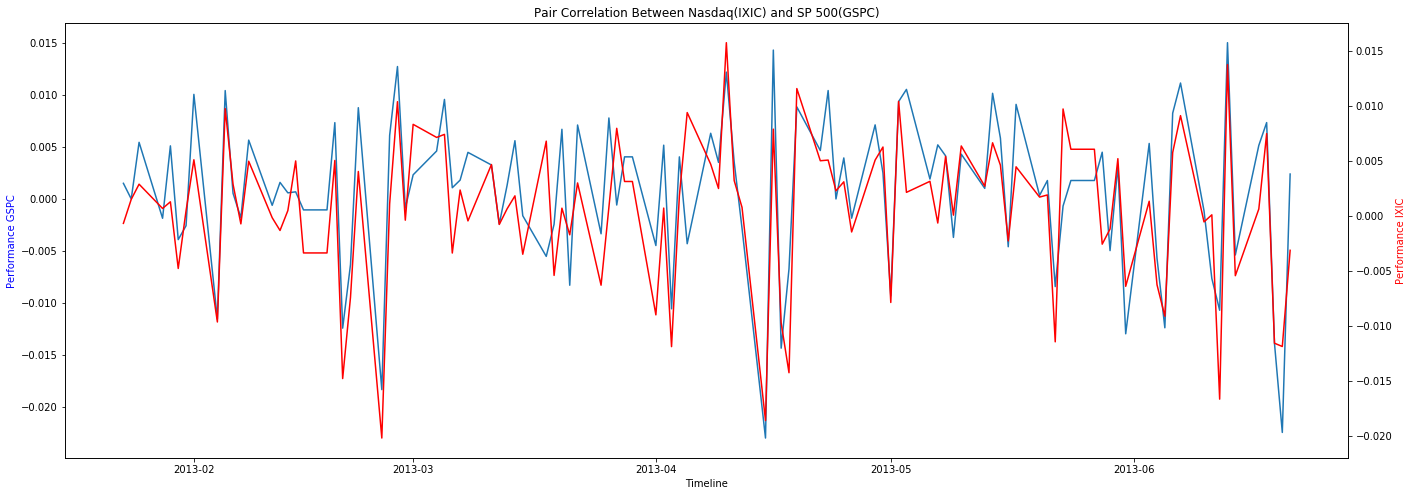

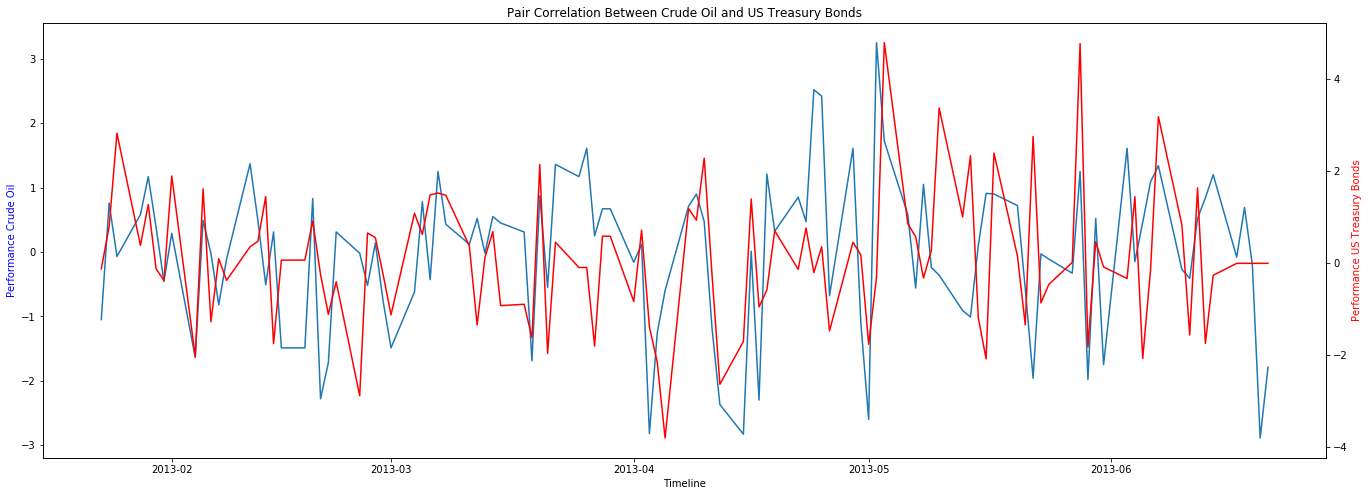

In [39]:
start_time = datetime(year=2013, month=1, day=23)
end_time = datetime(year=2013, month=6, day=23)
showPercentageCorrelation('Yahoo!', ['GSPC.csv', 'IXIC.csv'], factors_folder, start_time, end_time, 'Pair Correlation Between Nasdaq(IXIC) and SP 500(GSPC)', 'Performance GSPC', 'Performance IXIC')
showPercentageCorrelation('Investing.com', ['crudeoil.tsv', 'us30yeartreasurybonds.tsv'], factors_folder, start_time, end_time, 'Pair Correlation Between Crude Oil and US Treasury Bonds', 'Performance Crude Oil', 'Performance US Treasury Bonds')

**COMMENT**<br>
Here we have represented the correlation among some selected market factor in a different way: in particular we have used two twin plots to represent the lowest and the highest correlated factors (on randomly chosen six months in order to better visualize the differences between their values).

From the results obtained we can see that the highest correlation is the one between GSPC (S&P 500 Index) and IXIC (Nasdaq Composite); as said above, this is really evident from the heatmap and from the printed correlation matrix, with a value higher than 0.95. Instead, the lowest correlation is the one between Crude Oil and US Treasury Bonds, with a value of 0.38.

So what we did in this case is to represent the percentage change on a (randomly) selected time period of the two factors on the same graph. This is also really done in practice to visualize the correlation trend between different indexes.

The obtained results are really self explicative; for example, in the first plot (highest correlated factors), with an attentive analysis it's really evident that in most cases the trend is exactly the same for both the factors: at the positive change of one of the two factors, we have a positive change also on the other one, and viceversa, at the negative change of one, we can see the negative change of the other.<br>
The opposite thing can be said for the second plot representing the lowest correlated factors.

The multivariate normal distribution can help here by taking the correlation information between the factors into account. Each sample from a multivariate normal distribution can be thought of as a vector. Given values for all of the dimensions but one, the distribution of values along that dimension is normal. But, in their joint distribution, the variables are not independent.

For this use case, we can write:

$$
\left(\begin{array}{c}f_{1}\\f_{2}\\f_{3}\\f_{4} \end{array}\right)
\sim N 
\left[
  \left(
    \begin{array}{c}
      \mu_1\\ \mu_2 \\ \mu_3 \\ \mu_4 
    \end{array}
  \right), 
  \left(
    \begin{array}{cccc}
      \sigma^2_1 & \rho_{12} \sigma_1\sigma_2 & \rho_{13} \sigma_1\sigma_3 & \rho_{14} \sigma_1\sigma_4 \\ 
      \rho_{12}\sigma_2\sigma_1 & \sigma^2_2 & \rho_{23} \sigma_2\sigma_3 & \rho_{24} \sigma_2\sigma_4\\
      \rho_{13} \sigma_3\sigma_1 & \rho_{23} \sigma_3\sigma_2 & \sigma^2_3 & \rho_{34} \sigma_3\sigma_4 \\ 
      \rho_{14} \sigma_4\sigma_1 & \rho_{24} \sigma_4\sigma_2 & \rho_{34} \sigma_3\sigma_4 & \sigma_4^2 \\ 
    \end{array}
  \right)
\right]
$$

Or,

$$
f_t \sim N(\mu, \sum)
$$

Where $f_1$, $f_2$, $f_3$ and $f_4$ are the market factors, $\sigma_i$ is the standard deviation of factor $i$, $\mu$ is a vector of the empirical means of the returns of the factors and $\sum$ is the empirical covariance matrix of the returns of the factors.

The multivariate normal is parameterized with a mean along each dimension and a matrix describing the covariance between each pair of dimensions. When the covariance matrix is diagonal, the multivariate normal reduces to sampling along each dimension independently, but placing non-zero values in the off-diagonals helps capture the relationships between variables. Whenever having the mean of this multivariate normal distribution and its covariance matrix, we can generate the sample values for market factors.

Next, we will calculate the mean and the covariance matrix of this multivariate normal distribution from the historical data.


Text(114,0.5,'Factors')

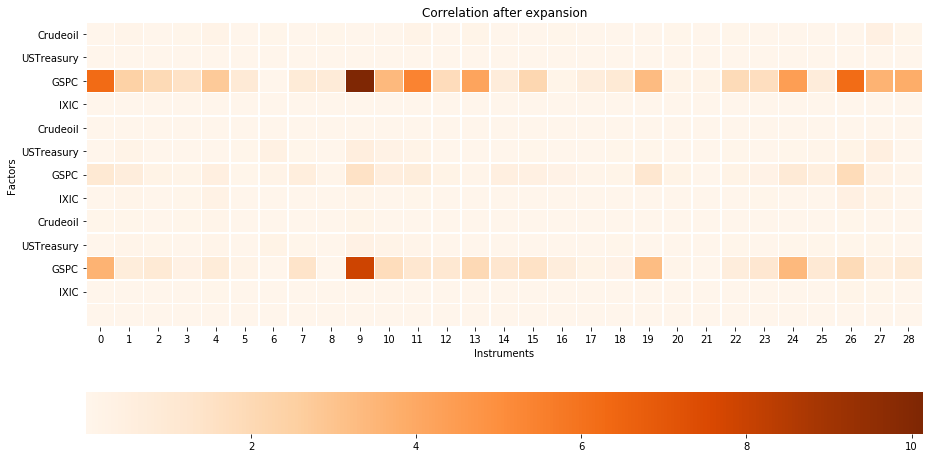

In [40]:
plt.figure(figsize=(15,8))
ax = plt.gca()

factor_names_3 = factor_names*3

tmp = transpose(list(map(lambda x: list(map(abs, x.tolist())), weights)))
sns.heatmap(tmp, yticklabels=factor_names_3, cmap='Oranges', linewidths=.5, cbar_kws={"orientation": "horizontal"}, ax=ax)
ax.set_title('Correlation after expansion')
ax.set_xlabel('Instruments')
ax.set_ylabel('Factors')

**COMMENT**<br>
Here we have analyzed the weights between factors and instruments after the expansion. Given the calculus above, we have:
* the first row of our heatmap is the intercept
* then we have the four squared factors
* then we have the four sqrt factors
* and then we have the four linear factors.

The 3 quadruples with the four factors are in this order: crudeoil, us treasury bonds, GSPC and IXIC.

Here it's evident that it's US Treasury that gives more informations. In fact, the tonalities of the resulting heatmap are uniform and conducive to the lowest correlation values except for the lines with the treasury bonds. This is the most influential feature in all its expansions, with the squared as the most significant value; linear and sqrt are the least significatives.

This kind of analysis can be used for the cases where we have to analyze lots of different informations (factors) to determine which one should be kept and which ones don't impact the value of the instruments.

NB: in this case we have chosen a different color palette with respect to the one above, as otherwise we would have had a mostly black diagram which would have been really bad to see. So in this case whiter is lower.

#### Question 6.2
<div class="alert alert-info">

Calculate the covariance matrix $\sum$ and the means $\mu$ of factors' returns then generate a random vector of factors return that follows a multivariate normal distribution $\sim N(\mu, \sum)$

</div>

<div class="label label-success">HINT</div>
Function `np.cov` can help calculating covariance matrix. Function `np.random.multivariate_normal(<mean>, <cov>)` is often used for generating samples.

In [41]:
factorCov = np.cov(factorsReturns)
factorMeans = np.mean(factorsReturns, axis=1)
sample = np.random.multivariate_normal(factorMeans, factorCov)
print("Covariance Matrix:\n", factorCov)
print("\nMeans:\n", factorMeans)
print("\nRandom vector of factors return:\n", sample)

Covariance Matrix:
 [[2.03712313e+01 2.63083547e-01 7.77281497e+01 1.72733934e+02]
 [2.63083547e-01 2.25820330e-02 3.19031608e+00 7.31494329e+00]
 [7.77281497e+01 3.19031608e+00 1.31938031e+03 2.88775882e+03]
 [1.72733934e+02 7.31494329e+00 2.88775882e+03 6.96989443e+03]]

Means:
 [ 3.59088803e-01 -1.31351351e-03  6.95386859e+00  1.87092273e+01]

Random vector of factors return:
 [-4.93810938  0.09383552 -2.72295945  3.75516087]


**COMMENT**<br>
Given those values, it is now possibile to generate vectors which follows a multivariate normal distribution. So, at this point, it could be interesting to see if a Gaussian model could be good for approximating the real distribution.

In [42]:
# plot the two given distributions
# we want to see how well our distribution approximates the real one
def plotDistributions(sample1, sample2, title=None, proposedDistributionLabel=None):
    vmin = min(sample1)
    vmax = max(sample1)
    stddev = np.std(sample1)
    
    domain = np.arange(vmin, vmax, (vmax-vmin)/1000)
    
    # a simple heuristic to select bandwidth
    bandwidth = 1.06 * stddev * pow(len(sample1), -.2)
    
    # estimate density
    kde = KDEUnivariate(sample1)
    kde.fit(bw=bandwidth)
    densityReal = kde.evaluate(domain)
    
    kde = KDEUnivariate(sample2)
    kde.fit(bw=bandwidth)
    densityProposed = kde.evaluate(domain)
    
    # plot
    plt.figure(figsize=(15,8))
    plt.plot(domain, densityReal, label='Real Distribution')
    if proposedDistributionLabel:
        plt.plot(domain, densityProposed, label= proposedDistributionLabel)
    else:
        plt.plot(domain, densityProposed, label='Proposed Distribution')
    if title: plt.title(title)
    plt.legend()
    plt.show()

In [43]:
# utility function that we use to return multiple samples belonging to a certain distribution
# there are multiple cases managed inside the function to manage all the possibile cases with parameters combinations
# This because each 'distribution' function (exponential, uniform, triangular, etc.) wants different kind of parameteres 
# and we wanted to generalize this process
def getDistributionSamples(sample_number, factors_number, distribution, *params, isExp=False):
    samples = []
    
    # just choose the right number of parameters
    # loop and append samples
    if(len(params) == 1):
        if(isExp):
            for i in range(sample_number):
                samples.append(distribution(size=params[0]))
        else:
            for i in range(sample_number):
                samples.append(distribution(params[0]))
    elif(len(params) == 2):
        for i in range(sample_number):
            samples.append(distribution(params[0], params[1]))
    elif(len(params) == 3):
        for i in range(sample_number):
            samples.append(distribution(params[0], params[1], params[2]))
    else:
        for i in range(sample_number):
            samples.append(distribution())
            
    samples = np.array(samples)
    
    # take columns and reorganize output
    samples2 = []
    for i in range(factors_number):
        samples2.append(samples[:,i])
        
    return samples2

In [44]:
samples = getDistributionSamples(100000, 4, np.random.multivariate_normal, factorMeans, factorCov)

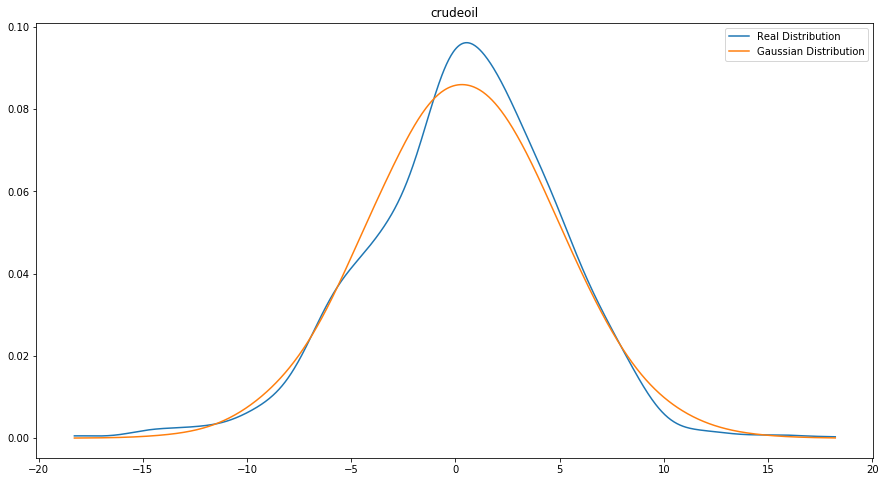

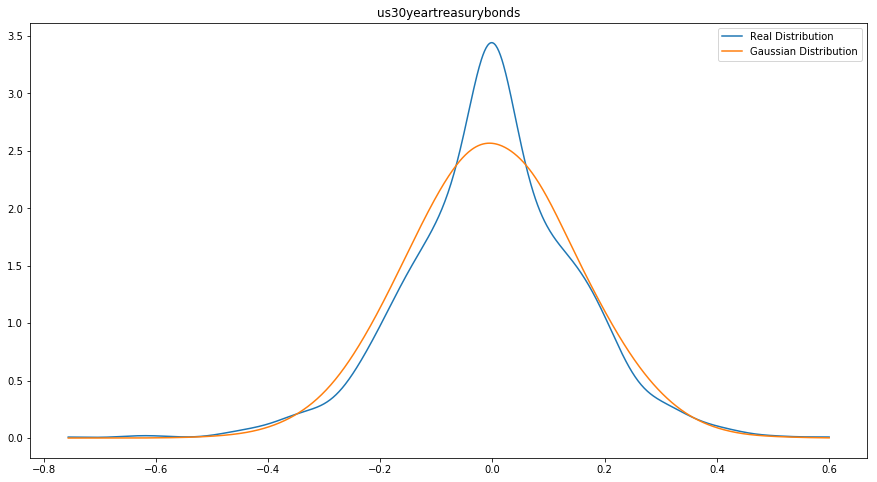

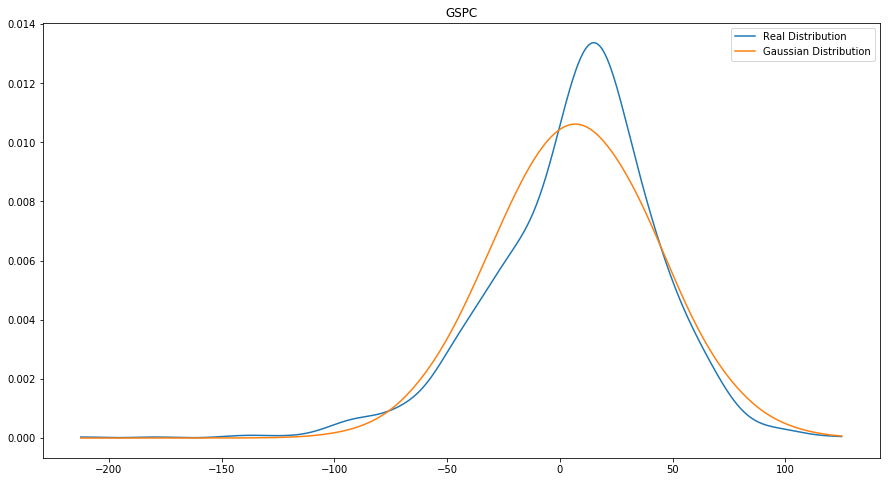

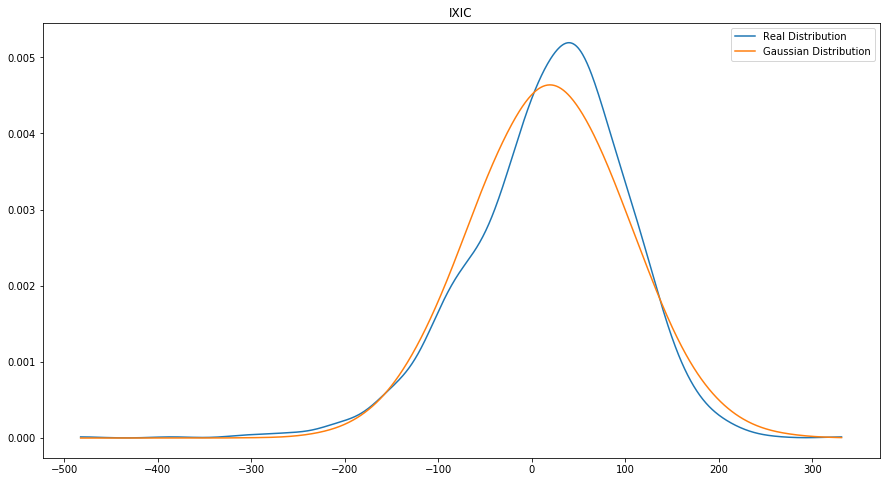

In [45]:
plotDistributions(factorsReturns[0], samples[0], factor1_files[0].split(".")[0], 'Gaussian Distribution')
plotDistributions(factorsReturns[1], samples[1], factor1_files[1].split(".")[0], 'Gaussian Distribution')
plotDistributions(factorsReturns[2], samples[2], factor2_files[0].split(".")[0], 'Gaussian Distribution')
plotDistributions(factorsReturns[3], samples[3], factor2_files[1].split(".")[0], 'Gaussian Distribution')

**COMMENT**<br>
Given the set of produced plots, we can see that the multivariate normal distribution can approximate really well the read data distribution; in most cases in fact, the two curves are really similar.<br>
We will see again this comparison with others distributions later on.

### Step 3&4: Generating samples, running simulation and calculating the VaR

We define some functions that helps us calculating VaR 5%. You will see that the functions below are pretty complicated! This is why we provide a solution for you: however, study them well!!

The basic idea of calculating VaR 5% is that we need to find a value such that only 5% of the losses are bigger than it. That means the 5th percentile of the losses should be VaR 5%.

VaR can sometimes be problematic though, since it does give any information on the extent of the losses which can exceed the VaR estimate. CVar is an extension of VaR that is introduced to deal with this problem. Indeed, CVaR measures the expected value of the loss in those cases where VaR estimate has been exceeded.

In [46]:
def fivePercentVaR(trials):
    numTrials = trials.count()
    topLosses = trials.takeOrdered(max(round(numTrials/20.0), 1))
    return topLosses[-1]

# an extension of VaR
def fivePercentCVaR(trials):
    numTrials = trials.count()
    topLosses = trials.takeOrdered(max(round(numTrials/20.0), 1))
    return sum(topLosses)/len(topLosses)

def bootstrappedConfidenceInterval(
      trials, computeStatisticFunction,
      numResamples, pValue):
    stats = []
    for i in range(0, numResamples):
        resample = trials.sample(True, 1.0)
        stats.append(computeStatisticFunction(resample))
    sorted(stats)
    lowerIndex = int(numResamples * pValue / 2 - 1)
    upperIndex = int(np.ceil(numResamples * (1 - pValue / 2)))
    return (stats[lowerIndex], stats[upperIndex])

Next, we will run the Monte Carlo simulation 10,000 times, in parallel using Spark. Remember to set the parallelism value accordingly.

### Question 7
<div class="alert alert-info">
Complete the code below to define the simulation process and calculate VaR 5%.
</div>

In [47]:
# RUN SIMULATION

# Compute returns assuming a multivariate normal distribution for the market factors
def simulateTrialReturns(numTrials, factorMeans, factorCov, factor3, weights):
    trialReturns = []
    for i in range(0, numTrials):
        # generate sample of factors' returns
        trialFactorReturns = np.random.multivariate_normal(factorMeans, factorCov)
        
        # featurize the factors' returns
        trialFeatures = featurize(trialFactorReturns.tolist())
        
        # insert weight for intercept term
        trialFeatures.insert(0,1)
        
        trialTotalReturn = 0
        
        # calculate the return of each instrument
        # then calculate the total of return for this trial features
        instrumentsReturn = 0
        for j in range(len(weights)):
            instrumentsReturn += weights[j]*trialFeatures
        trialTotalReturn = sum(instrumentsReturn)
        
        trialReturns.append(trialTotalReturn)
    return trialReturns


parallelism = 4
numTrials = 10000
trial_indexes = list(range(0, parallelism))
seedRDD = sc.parallelize(trial_indexes, parallelism)
bFactorWeights = sc.broadcast(weights)

trials = seedRDD.flatMap(lambda idx: \
                simulateTrialReturns(
                    max(int(numTrials/parallelism), 1), 
                    factorMeans, factorCov, 0,
                    bFactorWeights.value
                ))
trials.cache()
valueAtRisk = fivePercentVaR(trials)
conditionalValueAtRisk = fivePercentCVaR(trials)

print("Value at Risk(VaR) 5%:", valueAtRisk)
print("Conditional Value at Risk(CVaR) 5%:", conditionalValueAtRisk)

Value at Risk(VaR) 5%: -20.27116252426266
Conditional Value at Risk(CVaR) 5%: -25.96498284073063


The value of VaR depends on how many invested stocks and the chosen distribution of random variables. Assume that we get VaR 5% = -2.66,  that means that there is a 0.05 probability that the portfolio will fall in value by more than \$2.66 over a two weeks' period if there is no trading. In other words, the loses are less than \$2.66 over two weeks' period with 95% confidence level. When a loss over two weeks is more than \$2.66, we call it **failure** (or **exception**). Informally, because of 5% probability, we expect that there are only $0.05*W$ failures out of total $W$ windows.

### Step 5: Evaluating the results using backtesting method
In general, the error in a Monte Carlo simulation should be proportional to 1/sqrt(n), where n is the number of trials. This means, for example, that quadrupling the number of trials should approximately cut the error in half. A good way to check the quality of a result is backtesting on historical data. Backtesting is a statistical procedure where actual losses are compared to the estimated VaR. For instance, if the confidence level used to calculate VaR is 95% (or VaR 5%), we expect only 5 failures over 100 two-week time windows.

The most common test of a VaR model is counting the number of VaR failures, i.e., in how many windows, the losses exceed VaR estimate. If the number of exceptions is less than selected confidence level would indicate, the VaR model overestimates the risk. On the contrary, if there are too many exceptions, the risk is underestimated. However, it's very hard to observe the amount of failures suggested by the confidence level exactly. Therefore, people try to study whether the number of failures is reasonable or not, or will the model be accepted or rejected.

One common test is Kupiec's proportion-of-failures (POF) test. This test considers how the portfolio performed at many historical time intervals and counts the number of times that the losses exceeded the VaR. The null hypothesis is that the VaR is reasonable, and a sufficiently extreme test statistic means that the VaR estimate does not accurately describe the data. The test statistic is computed as:

$$
-2ln\Bigg(\frac{(1-p)^{T-x}p^x}{(1-\frac{x}{T})^{T-x}(\frac{x}{T})^x}\Bigg)
$$

where:

$p$ is the quantile-of-loss of the VaR calculation (e.g., in VaR 5%, p=0.05),

$x$ (the number of failures) is the number of historical intervals over which the losses exceeded the VaR 

$T$ is  the total number of historical intervals considered

Or we can expand out the log for better numerical stability:

$$
\begin{equation}
-2\Big((T-x)ln(1-p)+x*ln(p)-(T-x)ln(1-\frac{x}{T})-x*ln(\frac{x}{T})\Big)
\end{equation}
$$

If we assume the null hypothesis that the VaR is reasonable, then this test statistic is drawn from a chi-squared distribution with a single degree of freedom. By using Chi-squared distribution, we can find the `p-value` accompanying our test statistic value.  If `p-value` exceeds the critical value of the Chi-squared distribution, we do have sufficient evidence to reject the null hypothesis that the model is reasonable. Or we can say, in that case, the model is considered as inaccurate.

For example, assume that we calculate VaR 5% (the confidence level of the VaR model is 95%) and get value VaR = 2.26. We also observed 50 exceptions over 500 time windows. Using the formula above, the test statistic `p-value` is calculated and equal to `8.08`. Compared to `3.84`, the critical value of Chi-squared distribution with one degree of freedom at probability 5%, the test statistic is larger. So, the model is rejected. The critical values of Chi-squared can be found by following [this link](https://people.richland.edu/james/lecture/m170/tbl-chi.html).
However, in this Notebook, it's not a good idea to find the corresponding critical value by looking in a "messy" table, especially when we need to change the confidence level. Instead, from `p-value`, we will calculate the probability of the test statistic in Chi-square thanks to some functions in package `scipy`. If the calculated probability is smaller than the quantile of loss (e.g, 0.05), the model is rejected and vice versa.


### Question 8

#### Question 8.1
<div class="alert alert-info">

Write a function to calculate the number of failures, that is when the losses (in the original data) exceed the VaR.

</div>

<div class="label label-success">HINT</div>
<ul>
  <li>First, we need to calculate the total loss in each 2-week time interval</li>
  <li>If the total loss of a time interval exceeds VaR, then we say that our VaR fails to estimate the risk in that time interval</li>
  <li>Return the number of failures</li>
</ul>  

<div class="label label-danger">NOTE</div> The loss is often having negative value, so, be careful when compare it to VaR.

In [48]:
from scipy import stats
import math

def countFailures(stocksReturns, valueAtRisk):
    failures = 0
    # iterate over time intervals
    for i in range(0, len(stocksReturns[0])):
        # calculate the losses in each time interval
        loss = -sum(stock_return[i] for stock_return in stocksReturns)
        
        # if the loss exceeds VaR
        if loss > -valueAtRisk:
            failures += 1
    return failures

#### Question 8.2
<div class="alert alert-info">

Write a function named `kupiecTestStatistic` to calculate the test statistic which was described in the above equation.

</div>

In [49]:
def kupiecTestStatistic(total, failures, confidenceLevel):
    failureRatio = failures/total
    logNumer = (total-failures)*math.log(1-confidenceLevel) + failures*math.log(confidenceLevel)
    logDenom = (total-failures)*math.log(1-failureRatio) + failures*math.log(failureRatio)
    return -2 * (logNumer - logDenom)
    
# test the function
assert (round(kupiecTestStatistic(250, 36, 0.1), 2) == 4.80), "function kupiecTestStatistic runs incorrectly"

Now we can find the p-value accompanying our test statistic value.

In [50]:
def kupiecTestPValue(stocksReturns, valueAtRisk, confidenceLevel):
    failures = countFailures(stocksReturns, valueAtRisk)
    N = len(stocksReturns)
    print("num failures:", failures)
    total = len(stocksReturns[0])
    testStatistic = kupiecTestStatistic(total, failures, confidenceLevel)
    #return 1 - stats.chi2.cdf(testStatistic, 1.0)
    return stats.chi2.sf(testStatistic, 1.0)

varConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentVaR, 100, 0.05)
cvarConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentCVaR, 100, .05)
print("VaR confidence interval: " , varConfidenceInterval)
print("CVaR confidence interval: " , cvarConfidenceInterval)
print("Kupiec test p-value: " , kupiecTestPValue(stocksReturns, valueAtRisk, 0.05))

VaR confidence interval:  (-20.04046132522862, -20.5269648345526)
CVaR confidence interval:  (-26.384681081708056, -26.081324471885768)
num failures: 112
Kupiec test p-value:  4.1402731285861676e-08


In [51]:
# Print how many time windows we have analyzed
print("T:", len(stocksReturns[0]))

T: 1295


#### Question 8.3
<div class="alert alert-info">

Discuss the results you have obtained

</div>

Value-at-Risk (VaR) is a risk measure which estimates the expected loss of a fixed portfolio during the next T trading days (in this case two weeks) for a given probability level p (in this case 95%). Thus, the total risk of a portfolio is measured through a single number. Due to the fact that it is simple and easy to understand, VaR has become very popular and it is widely used by financial institutions.<br>
In this case our VaR confidence interval is between -20.40 and -20.69, which is a relatively small interval if we consider that we are investing in 29 stocks (each with a different price). So apparently this could be a good prediction for us, however, the results obtained with the Kupiec test does not assure us that this is a reliable result.<br>
Conditional value at risk (CVaR) is another risk assessment technique often used to reduce the probability that a portfolio will incur large losses. This is performed by assessing the likelihood (at a specific confidence level) that a specific loss will exceed the value at risk. In this case, it has a very tight confidence interval with values not too far from the VaR ones; so this would mean that, in the worst case, we should not lose too much.

However, those predictions are likely to be falsified, as we can see from the Kupiec value.

Kupiec formulated the unconditional coverage test which checks, by means of a likelihood ratio test statistic, if the percentage of violations is statistically equivalent to the VaR probability level p.
<table>
    <tr>
        <th>Probability level p</th>
        <th>VAR confidence level</th>
        <th>T = 255 days</th>
        <th>T = 510 days</th>
        <th>T = 1000 days</th>
    </tr>
    <tr>
        <td>0.01</td>
        <td>99%</td>
        <td>N < 7 </td>
        <td>1 < N < 11 </td>
        <td>4 < N < 17 </td>
    </tr>
    <tr>
        <td>0.025</td>
        <td>97.5%</td>
        <td>2 < N < 12 </td>
        <td>6 < N < 21 </td>
        <td>15 < N < 36 </td>
    </tr>
    <tr>
        <td>0.05</td>
        <td>95%</td>
        <td>6 < N < 21 </td>
        <td>16 < N < 36 </td>
        <td>37 < N < 65 </td>
    </tr>
    <tr>
        <td>0.075</td>
        <td>92.5%</td>
        <td>11 < N < 28 </td>
        <td>27 < N < 51 </td>
        <td>59 < N < 92 </td>
    </tr>
    <tr>
        <td>0.1</td>
        <td>90%</td>
        <td>16 < N < 36 </td>
        <td>38 < N < 65 </td>
        <td>81 < N < 120 </td>
    </tr>
</table>

Here we have reported a (example) table representing non rejection regions for the POF-test under differente confidence levels and sample sizes. The table shows how the power of the test increases as the sample size gets larger.<br>
For instance, in our case (at 95% confidence), in case of T = 255 (observations), the interval for accepting the model is [6/255 = 0.024 , 21/255 = 0.082]; or in case of T = 1000 -> [37/1000 = 0.037, 65/1000 = 0.065].

In our case, we have T = 1295, with 108 failures: 108/1295 = 0.0834. So we can see that our failure percentage has already exceeded the 5% value. Moreover, we can see also that the Kupiec test p-value is very low, and way below 0.05, so we can say that our model is very bad: we have a model that in certain cases is not reliable at all; our data are unlikely with a true null.

### Question 9
<div class="alert alert-info">
Assume that we invest in more than 100 stocks. Use the same market factors as for the previous questions to estimate VaR by running MCS, then validate your result.  

What is the main observation you have, once you answer this question? When you plan to invest in more instruments, how is your ability to predict the risk going to be affected?
</div>


In [52]:
def readStocks(numStocks, num_years, stock_folder):
    # select path of all stock data files in "stock_folder"
    files = [join(stock_folder, f) for f in listdir(stock_folder) if isfile(join(stock_folder, f))]
    files = files[:numStocks]

    # read each line in each file, convert it into the format: (date, value)
    rawStocks = [process_stock_file(f) for f in files]

    # select only instruments which have more than num_years years of history
    # Note: the number of business days in a year is 260
    number_of_years = num_years
    print('Initial number of stocks: ',len(rawStocks))
    rawStocks = list(filter(lambda instrument: len(instrument) > (260*number_of_years) , rawStocks))
    print('Number of used stocks: ', len(rawStocks), end='\n\n')
    return rawStocks

In [53]:
def trimInstrument(raw, start=datetime(year=2009, month=1, day=23), end=datetime(year=2014, month=1, day=23)):
    # trim into a specific time region
    # and fill up the missing values
    res = list(map(lambda x: \
                fillInHistory(
                    trimToRegion(x, start, end), 
                start, end), 
            raw))
    return res

In [54]:
def computeStockTwoWeekReturn(stocks):
    #Compute the returns over all two week time windows
    stocksReturns = list(map(twoWeekReturns, stocks))
    return stocksReturns

In [55]:
def computeWeights(stocksReturns, factorsReturns):
    factorMat = transpose(matrix=factorsReturns)
    factorFeatures = list(map(lambda factor:featurize(factor), factorMat))
    factor_columns = np.array(factorFeatures)
    factor_columns = sm.add_constant(factor_columns, prepend=True)
    
    # estimate weights using the same factors we used for previous questions (CrudeOil, IXIC, GSPC, USTreasuryBonds)
    weights = [estimateParams(stockReturns, factor_columns) for stockReturns in stocksReturns]
    return weights

In [56]:
# Function to run MonteCarlo Simulation
# factorParameters depends on the distribution we want to use to approximate factors inside 'simulateTrialReturns_func' function
# For example if I want to use a multivariate normal distribution I will pass the mean and covariance, thus I won't need factorParameter3
# It returns the Var, CVar and trials of this simulation
def MCSimulation(parallelism, numTrials, weights, factorParameter1, factorParameter2, factorParameter3, simulateTrialReturns_func):
    trial_indexes = list(range(0, parallelism))
    seedRDD = sc.parallelize(trial_indexes, parallelism)
    bFactorWeights = sc.broadcast(weights)

    trials = seedRDD.flatMap(lambda idx: \
                    simulateTrialReturns_func(
                        max(int(numTrials/parallelism), 1), 
                        factorParameter1, factorParameter2, factorParameter3,
                        bFactorWeights.value
                    ))
    trials.cache()
    valueAtRisk = fivePercentVaR(trials)
    conditionalValueAtRisk = fivePercentCVaR(trials)
    return valueAtRisk, conditionalValueAtRisk, trials

In [57]:
# utility function that prints out the most important information we can get from MCSimulation
# In particular it prints the Var, CVar, Kupiec test result, assuming a confidence level of 95%
def printResults95(VaR, CVaR, trials, stockReturns):
    print("Value at Risk(VaR) 5%:", VaR)
    print("Conditional Value at Risk(CVaR) 5%:", CVaR)
    varConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentVaR, 100, 0.05)
    cvarConfidenceInterval = bootstrappedConfidenceInterval(trials, fivePercentCVaR, 100, .05)
    print("\nVaR confidence interval: " , varConfidenceInterval)
    print("CVaR confidence interval: " , cvarConfidenceInterval)
    print("Kupiec test p-value: " , kupiecTestPValue(stockReturns, VaR, 0.05))

In [58]:
# run simulation
# using 150 stocks
rawStocks150 = readStocks(150, 5, stock_folder)
stocks150 = trimInstrument(rawStocks150)
stocksReturns150 = computeStockTwoWeekReturn(stocks150)
weights150 = computeWeights(stocksReturns150, factorsReturns)
valueAtRisk150, conditionalValueAtRisk150, trials150= MCSimulation(4, 10000, weights150, factorMeans, factorCov, 0, simulateTrialReturns)

# print out results
printResults95(valueAtRisk150, conditionalValueAtRisk150, trials150, stocksReturns150)

Initial number of stocks:  150
Number of used stocks:  115

Value at Risk(VaR) 5%: -552.5431290626116
Conditional Value at Risk(CVaR) 5%: -870.0812858092528

VaR confidence interval:  (-552.8210594822411, -559.2089332853889)
CVaR confidence interval:  (-848.3246767678505, -884.6610613935843)
num failures: 223
Kupiec test p-value:  1.0825140924498573e-57


**COMMENT**<br>
As requested here we have run the MC simulation using more than 100 stocks (in particular in this case we have decided to use 150 stocks). Among the 150 given stock, after the trim phase, we get 115 stocks, so this means that 35 stocks among the 150 selected have less than 5 years of information.

Before running the simulation we were expecting a worsening in the obtained results if compared to the ones above (with less stocks); in fact, above we were working with only 35 (indeed 29) different stocks, and it's not wrong to expect that if you invest in more stocks, the expected value at risk and confidence can increase.<br>
So the obtained results confirm what we were expecting, as in this case we have a VaR at 5% value around -500 and a CVaR around -900. Also the number of failures increases (by more than double its older value).

Also in this case (and in a much more evident way!), the Kupiec test tells us that our model is still not good and the actual predictions won't reflect a real case scenario.

### Question 10
<div class="alert alert-info">

In the previous questions, we used the normal distributions to sample the factors returns.  

Try to study how results vary when selecting other probability distributions: our goal is to improve the result of our MCS.
</div>

### 10.1 Uniform Distribution

In [59]:
# This is the same function we used above (simulateTrialReturns) but it uses a uniform distribution
# For this distribution it's necessary to provide a minimum and a maximum value
def simulateTrialReturns_uniform(numTrials, factorMins, factorMaxs, factor3, weights):
    trialReturns = []
    for i in range(0, numTrials):
        # generate sample of factors' returns
        trialFactorReturns = np.random.uniform(factorMins, factorMaxs)
        
        # featurize the factors' returns
        trialFeatures = featurize(trialFactorReturns.tolist())
        
        # insert weight for intercept term
        trialFeatures.insert(0,1)
        
        trialTotalReturn = 0
        
        # calculate the return of each instrument
        # then calculate the total of return for this trial features
        instrumentsReturn = 0
        for j in range(len(weights)):
            instrumentsReturn += weights[j]*trialFeatures
        trialTotalReturn = sum(instrumentsReturn)
        
        trialReturns.append(trialTotalReturn)
    return trialReturns

In [60]:
factorMins = np.min(factorsReturns, axis=1)
factorMaxs = np.max(factorsReturns, axis=1)

**COMMENT**<br>
Before going on with the MC simulation, we first want to have a graphical visualization of what we are doing. Given the real data distribution we have seen above (approximatively a gaussian), we expect the uniform distribution to not suit well our problem.

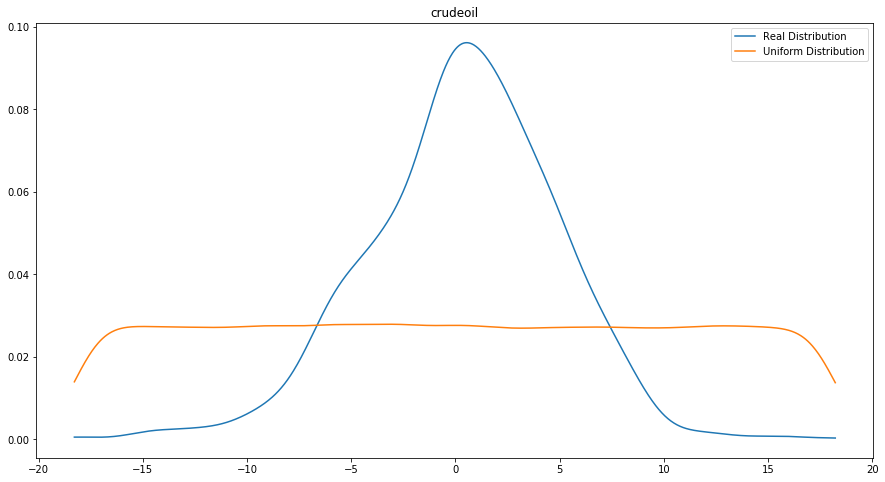

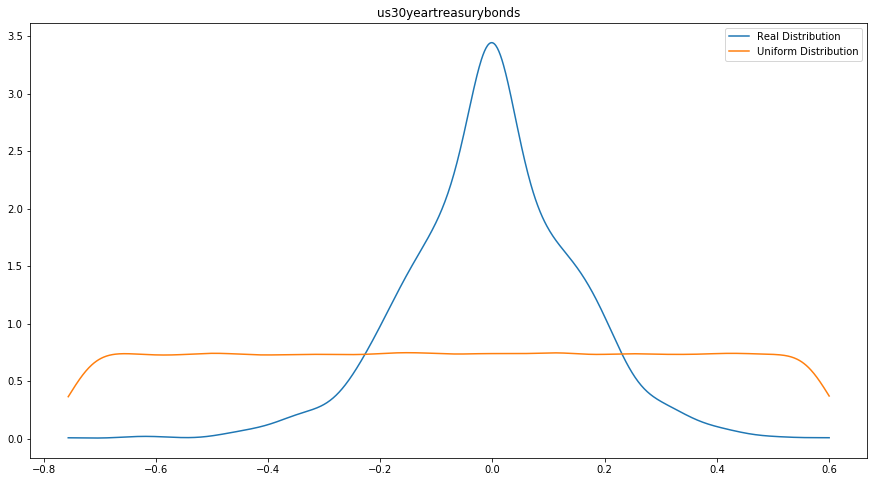

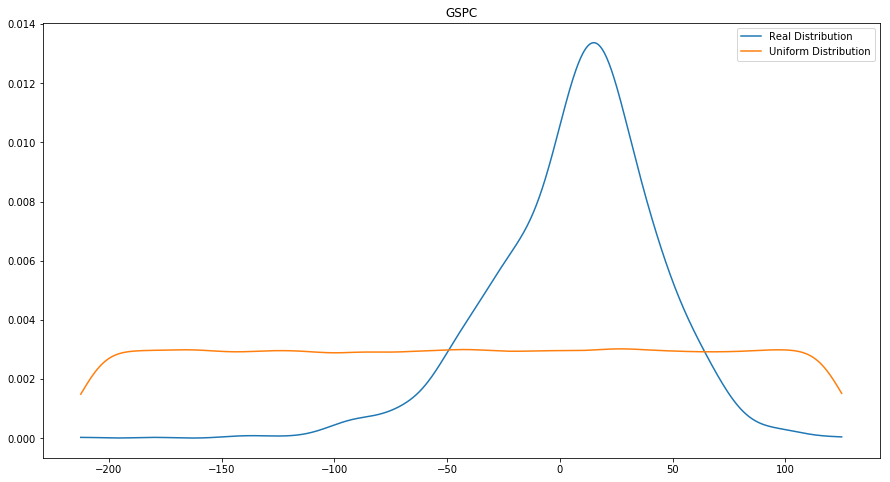

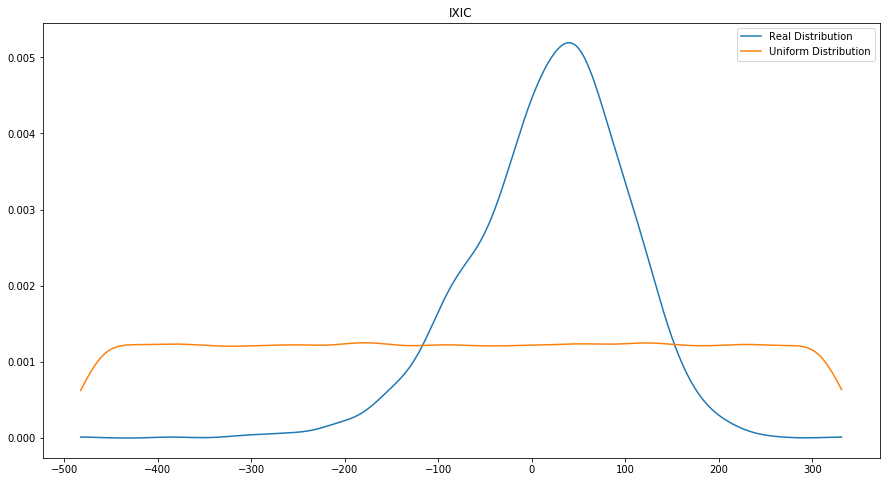

In [61]:
#Represents through plots how well the uniform distribution approximates the real factor distributions
samples = getDistributionSamples(100000, 4, np.random.uniform, factorMins, factorMaxs)
plotDistributions(factorsReturns[0], samples[0], factor1_files[0].split(".")[0], 'Uniform Distribution')
plotDistributions(factorsReturns[1], samples[1], factor1_files[1].split(".")[0], 'Uniform Distribution')
plotDistributions(factorsReturns[2], samples[2], factor2_files[0].split(".")[0], 'Uniform Distribution')
plotDistributions(factorsReturns[3], samples[3], factor2_files[1].split(".")[0], 'Uniform Distribution')

**COMMENT**<br>
As we can see from the plot above, the uniform distribution (due to the real data distribution) is probably one of the worst choices for addressing this problem.<br>
The proposed distribution is way far from being a good approximation for the real distribution.

Now we can see if this feeling is also reflected in the simulation results.

In [62]:
rawStocks150_uniform = readStocks(150, 5, stock_folder)
stocks150_uniform = trimInstrument(rawStocks150_uniform)
stocksReturns150_uniform = computeStockTwoWeekReturn(stocks150_uniform)
weights150_uniform = computeWeights(stocksReturns150_uniform, factorsReturns)
valueAtRisk150_uniform, conditionalValueAtRisk150_uniform, trials150_uniform= MCSimulation(4, 10000, weights150_uniform, factorMins, factorMaxs, 0, simulateTrialReturns_uniform)

printResults95(valueAtRisk150_uniform, conditionalValueAtRisk150_uniform, trials150_uniform, stocksReturns150_uniform)

Initial number of stocks:  150
Number of used stocks:  115

Value at Risk(VaR) 5%: -6015.751440617922
Conditional Value at Risk(CVaR) 5%: -7433.87365542229

VaR confidence interval:  (-5936.546293642024, -5969.410339529653)
CVaR confidence interval:  (-7270.856937599756, -7379.873953988631)
num failures: 35
Kupiec test p-value:  3.4528356934382664e-05


**COMMENT**<br>
The results confirm what we were expecting: the prediction made in this case are really bad in terms of VaR and CVaR as we obtain value which are way belowe than the ones obtained above, with a VaR and CVaR that are really really low.

However, here we get the best results in terms of p-value; this means that in this case the (bad) previsions made by the model are more accurated and close to the reality.

### 10.2 Triangular Distribution

In [63]:
# This is the same function we used above (simulateTrialReturns) but it uses a triangular distribution
# For this distribution it's necessary to provide a minimum, a maximum and the mode values
def simulateTrialReturns_triangular(numTrials, factorMins, factorModes, factorMaxs, weights):
    trialReturns = []
    for i in range(0, numTrials):
        # generate sample of factors' returns
        trialFactorReturns = np.random.triangular(factorMins, factorModes, factorMaxs)
        
        # featurize the factors' returns
        trialFeatures = featurize(trialFactorReturns.tolist())
        
        # insert weight for intercept term
        trialFeatures.insert(0,1)
        
        trialTotalReturn = 0
        
        # calculate the return of each instrument
        # then calculate the total of return for this trial features
        instrumentsReturn = 0
        for j in range(len(weights)):
            instrumentsReturn += weights[j]*trialFeatures
        trialTotalReturn = sum(instrumentsReturn)
        
        trialReturns.append(trialTotalReturn)
    return trialReturns

In [64]:
from scipy import stats

rawStocks150_triangular = readStocks(150, 5, stock_folder)
stocks150_triangular = trimInstrument(rawStocks150_triangular)
stocksReturns150_triangular = computeStockTwoWeekReturn(stocks150_triangular)
weights150_triangular = computeWeights(stocksReturns150_triangular, factorsReturns)

factorModes = [stats.mode(factor)[0][0] for factor in factorsReturns]
valueAtRisk150_triangular, conditionalValueAtRisk150_triangular, trials150_triangular= MCSimulation(4, 10000, weights150_triangular, factorMins, factorModes, factorMaxs, simulateTrialReturns_triangular)
printResults95(valueAtRisk150_triangular, conditionalValueAtRisk150_triangular, trials150_triangular, stocksReturns150_triangular)

Initial number of stocks:  150
Number of used stocks:  115

Value at Risk(VaR) 5%: -3666.7941548378967
Conditional Value at Risk(CVaR) 5%: -4735.985979102624

VaR confidence interval:  (-3700.0182063149305, -3731.5798699863353)
CVaR confidence interval:  (-4691.085331709954, -4809.854753364639)
num failures: 39
Kupiec test p-value:  0.00040882445394070145


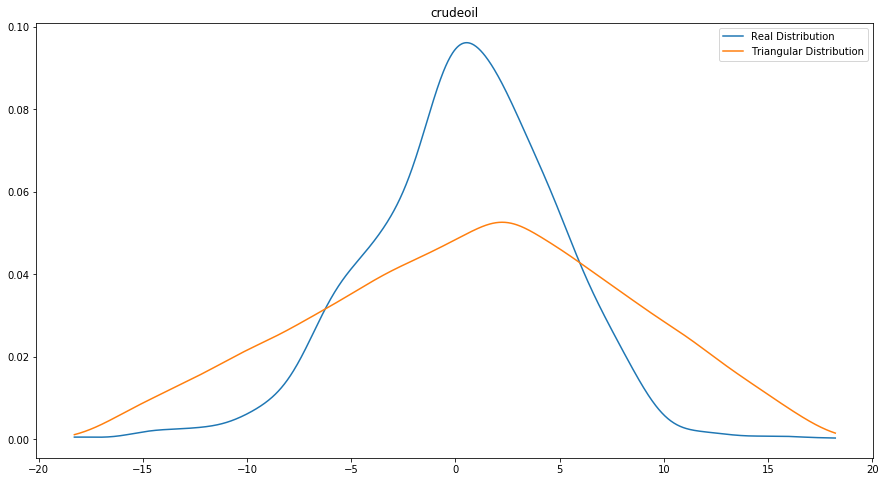

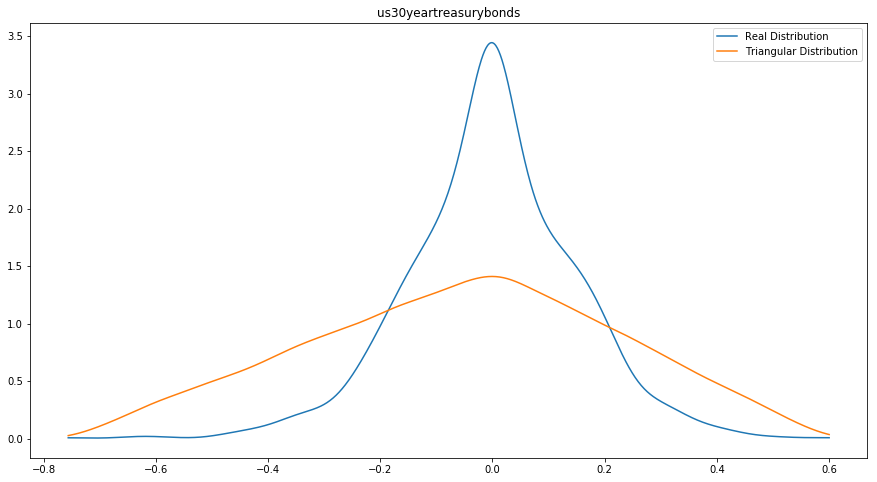

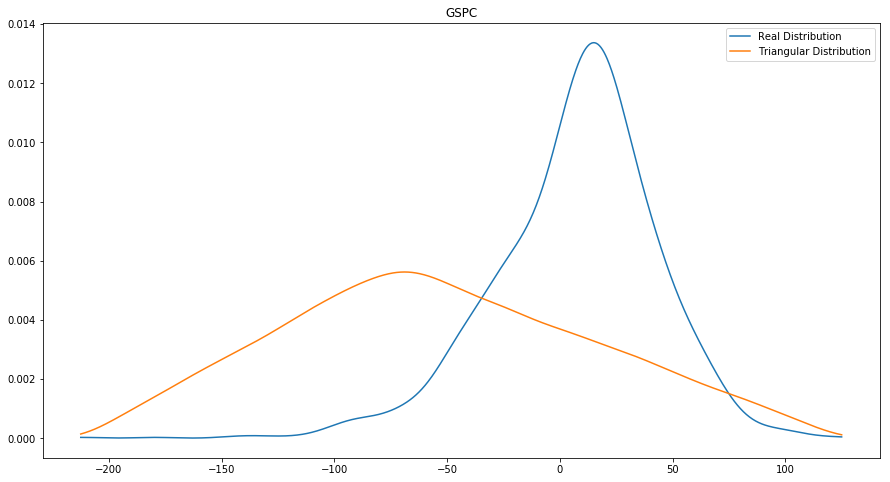

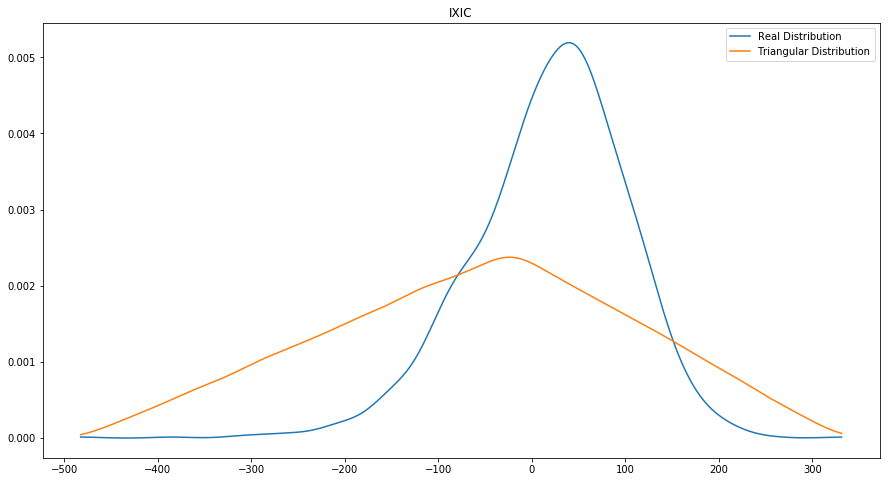

In [65]:
samples = getDistributionSamples(100000, 4, np.random.triangular, factorMins, factorModes, factorMaxs)
plotDistributions(factorsReturns[0], samples[0], factor1_files[0].split(".")[0], 'Triangular Distribution')
plotDistributions(factorsReturns[1], samples[1], factor1_files[1].split(".")[0], 'Triangular Distribution')
plotDistributions(factorsReturns[2], samples[2], factor2_files[0].split(".")[0], 'Triangular Distribution')
plotDistributions(factorsReturns[3], samples[3], factor2_files[1].split(".")[0], 'Triangular Distribution')

**COMMENT**<br>
From the plots above we can infer that the triangular distribution can approximate the real distribution better than the uniform one. This is confirmed by the result of the kupiec test and from the Var and CVar values that are smaller than the ones we obtained for the uniform distribution.

Also the Kupiec test gives really god results; despite the value is still below the region of acceptance described above, we can see that in this case the model appears to more accurate than the ones we have seen until now.

### 10.3 Exponential Distribution

In [66]:
# This is the same function we used above (simulateTrialReturns) but it uses an exponential distribution
# For this distribution it's necessary to provide a size parameter that represents the output shape of the sample of factors's return
def simulateTrialReturns_exponential(numTrials, factors_size, factor2, factor3, weights):
    trialReturns = []
    for i in range(0, numTrials):
        # generate sample of factors' returns
        trialFactorReturns = np.random.exponential(size=factors_size)
        
        # featurize the factors' returns
        trialFeatures = featurize(trialFactorReturns.tolist())
        
        # insert weight for intercept term
        trialFeatures.insert(0,1)
        
        trialTotalReturn = 0
        
        # calculate the return of each instrument
        # then calculate the total of return for this trial features
        instrumentsReturn = 0
        for j in range(len(weights)):
            instrumentsReturn += weights[j]*trialFeatures
        trialTotalReturn = sum(instrumentsReturn)
        
        trialReturns.append(trialTotalReturn)
    return trialReturns

In [67]:
rawStocks150_exponential = readStocks(150, 5, stock_folder)
stocks150_exponential = trimInstrument(rawStocks150_exponential)
stocksReturns150_exponential = computeStockTwoWeekReturn(stocks150_exponential)
weights150_exponential = computeWeights(stocksReturns150_exponential, factorsReturns)

valueAtRisk150_exponential, conditionalValueAtRisk150_exponential, trials150_exponential = MCSimulation(4, 10000, weights150_exponential, len(factorsReturns), 0, 0, simulateTrialReturns_exponential)
printResults95(valueAtRisk150_exponential, conditionalValueAtRisk150_exponential, trials150_exponential, stocksReturns150_exponential)

Initial number of stocks:  150
Number of used stocks:  115

Value at Risk(VaR) 5%: -227.66197421388787
Conditional Value at Risk(CVaR) 5%: -285.59853180008514

VaR confidence interval:  (-227.97319224114622, -228.11781876197776)
CVaR confidence interval:  (-282.78935787440736, -288.78172637091023)
num failures: 348
Kupiec test p-value:  8.889143971748937e-149


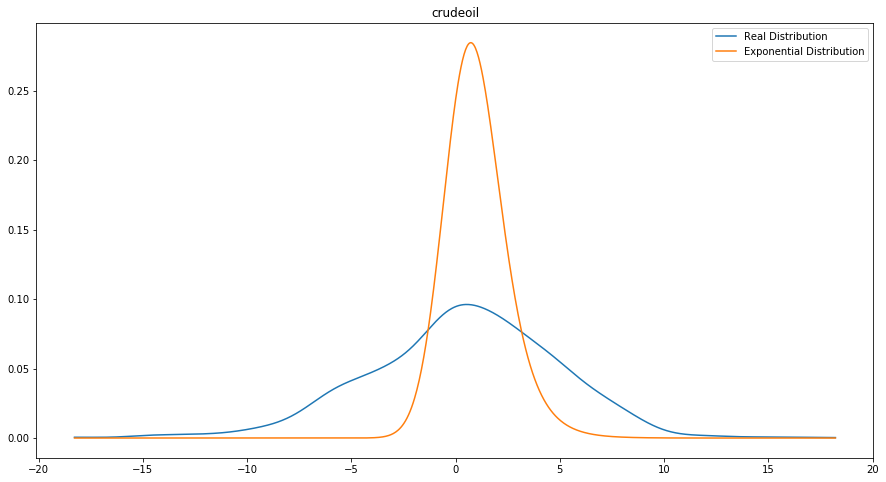

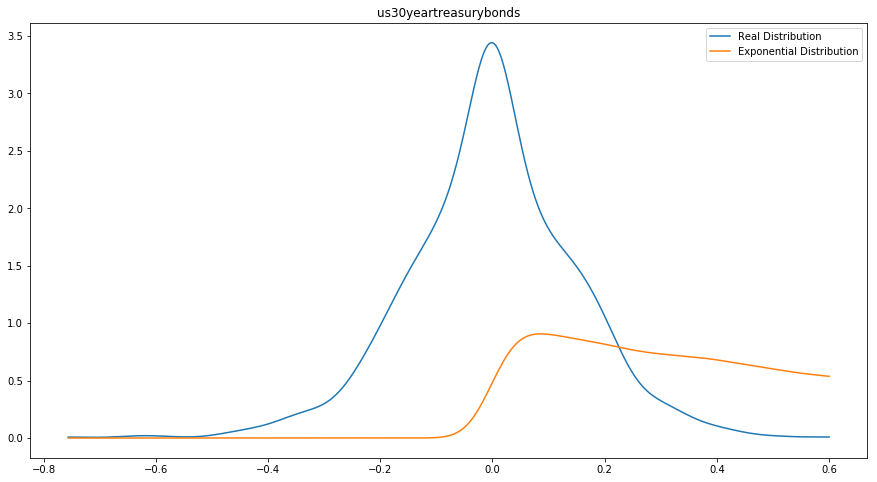

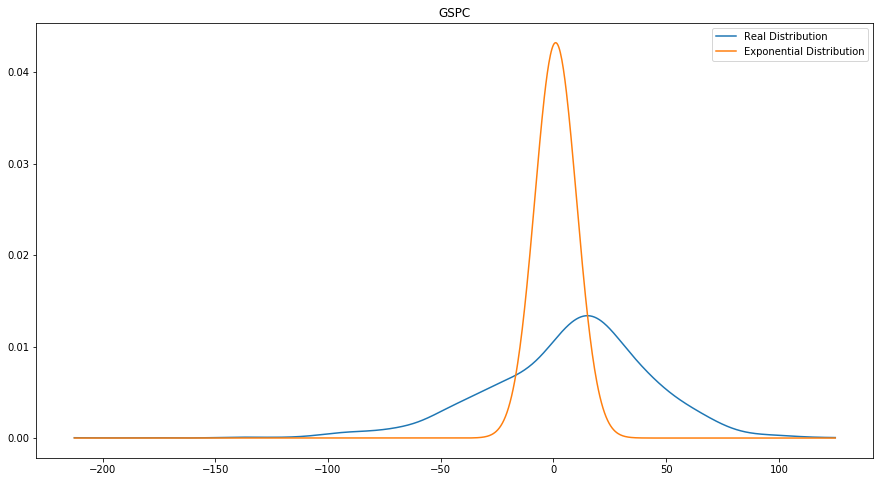

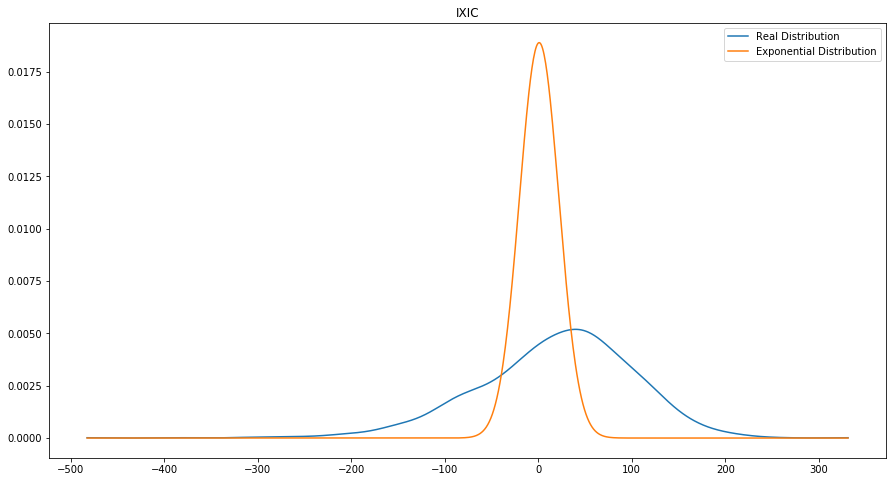

In [68]:
# Represent how well the exponential distribution approximates the real factors distributions
samples = getDistributionSamples(100000, 4, np.random.exponential, len(factorsReturns), isExp=True)
plotDistributions(factorsReturns[0], samples[0], factor1_files[0].split(".")[0], 'Exponential Distribution')
plotDistributions(factorsReturns[1], samples[1], factor1_files[1].split(".")[0], 'Exponential Distribution')
plotDistributions(factorsReturns[2], samples[2], factor2_files[0].split(".")[0], 'Exponential Distribution')
plotDistributions(factorsReturns[3], samples[3], factor2_files[1].split(".")[0], 'Exponential Distribution')

**COMMENT**<br>
From the plots above we can infer that the exponential distribution can not approximate well the real distribution, since it assumes shapes that are quite far from the real one. The Var and CVar values are small but the number of failures and the result of the kupiec test reflects the conclusion we made by only looking at the plots. 

# 6. Additional Analysis

## 6.1 More Factors

Goal of this section is to analyze an additional number of factors we downloaded from investing.com. In particular we will analyze:
* Dow Jones
* EUR-USD
* FTSE 100
* Gold
* MSCI
* US Dollar Index
* US SmallCap 2000

This required us an initial "preprocessing" phase on data (that we did outside the notebook) to create a suitable format to be used in the following steps.

In [69]:
# read data from local disk
def readInvestingDotComHistory_mod(fname, delimiter='\t'):
    def process_line(line):
        cols = line.split(delimiter)
        date = datetime.strptime(cols[0], "%b %d, %Y")
        value = float(cols[1].replace(",", ""))
        return (date, value)
    
    with open(fname) as f:
        content_w_header = f.readlines()
        # remove the first line 
        # and reverse lines to sort the data by date, in ascending order
        content = content_w_header[:0:-1]
        return list(map(process_line , content))

In [70]:
new_factor_files = ['Dow_Jones.tsv', 'EUR_USD.tsv', 'FTSE_100.tsv', 'Gold.tsv', 'MSCI.tsv', 'US_Dollar_Index.tsv', 'US_SmallCap_2000.tsv']
new_factor_files_map = map(lambda fn: factors_folder + fn, new_factor_files)
new_factors = [readInvestingDotComHistory_mod(f) for f in new_factor_files_map]

#### Dow_Jones #####
len: 2516
first 5: [(datetime.datetime(2007, 1, 4, 0, 0), 12480.69), (datetime.datetime(2007, 1, 5, 0, 0), 12398.01), (datetime.datetime(2007, 1, 8, 0, 0), 12423.49), (datetime.datetime(2007, 1, 9, 0, 0), 12416.6), (datetime.datetime(2007, 1, 10, 0, 0), 12442.16)]
last 5: [(datetime.datetime(2016, 12, 23, 0, 0), 19933.81), (datetime.datetime(2016, 12, 27, 0, 0), 19945.04), (datetime.datetime(2016, 12, 28, 0, 0), 19833.68), (datetime.datetime(2016, 12, 29, 0, 0), 19819.78), (datetime.datetime(2016, 12, 30, 0, 0), 19762.6)]


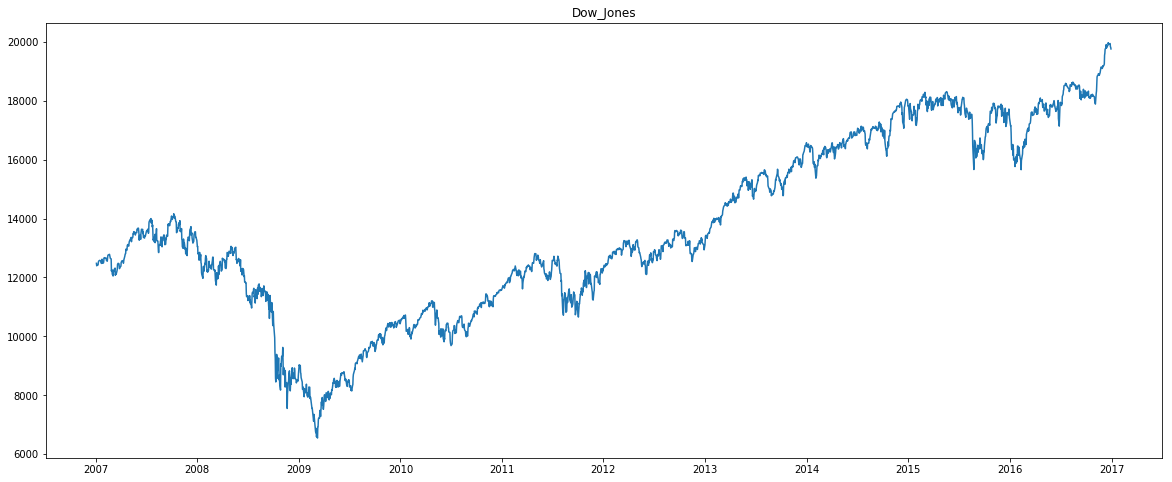

#### EUR_USD #####
len: 3690
first 5: [(datetime.datetime(2003, 1, 1, 0, 0), 1.0492), (datetime.datetime(2003, 1, 2, 0, 0), 1.0362), (datetime.datetime(2003, 1, 3, 0, 0), 1.0423), (datetime.datetime(2003, 1, 6, 0, 0), 1.0469), (datetime.datetime(2003, 1, 7, 0, 0), 1.0416)]
last 5: [(datetime.datetime(2016, 12, 27, 0, 0), 1.0457), (datetime.datetime(2016, 12, 28, 0, 0), 1.0412), (datetime.datetime(2016, 12, 29, 0, 0), 1.0492), (datetime.datetime(2016, 12, 30, 0, 0), 1.0516), (datetime.datetime(2017, 1, 1, 0, 0), 1.0526)]


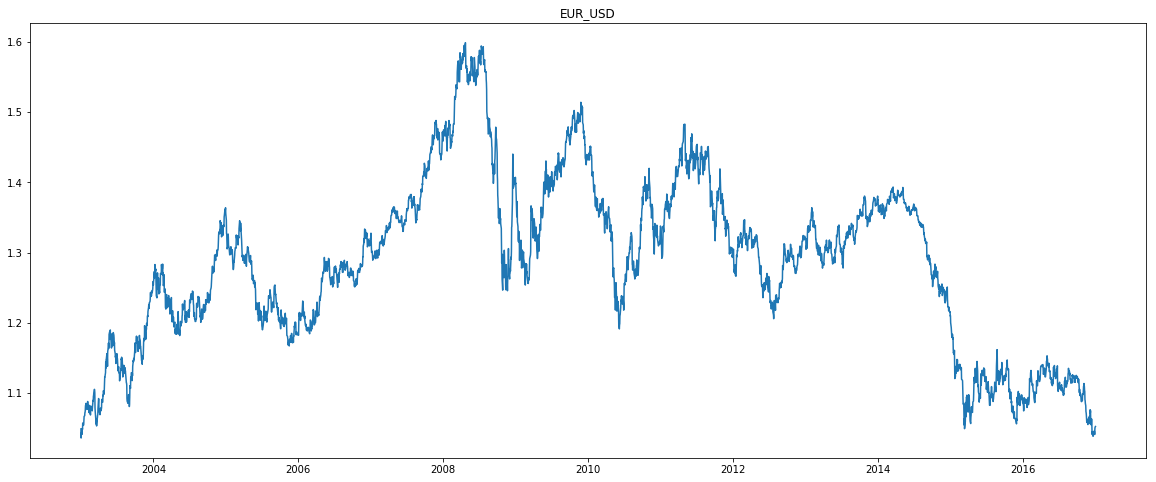

#### FTSE_100 #####
len: 1376
first 5: [(datetime.datetime(2011, 8, 15, 0, 0), 5350.58), (datetime.datetime(2011, 8, 16, 0, 0), 5357.63), (datetime.datetime(2011, 8, 17, 0, 0), 5331.6), (datetime.datetime(2011, 8, 18, 0, 0), 5092.23), (datetime.datetime(2011, 8, 19, 0, 0), 5040.76)]
last 5: [(datetime.datetime(2016, 12, 22, 0, 0), 7063.68), (datetime.datetime(2016, 12, 23, 0, 0), 7068.17), (datetime.datetime(2016, 12, 28, 0, 0), 7106.08), (datetime.datetime(2016, 12, 29, 0, 0), 7120.26), (datetime.datetime(2016, 12, 30, 0, 0), 7142.83)]


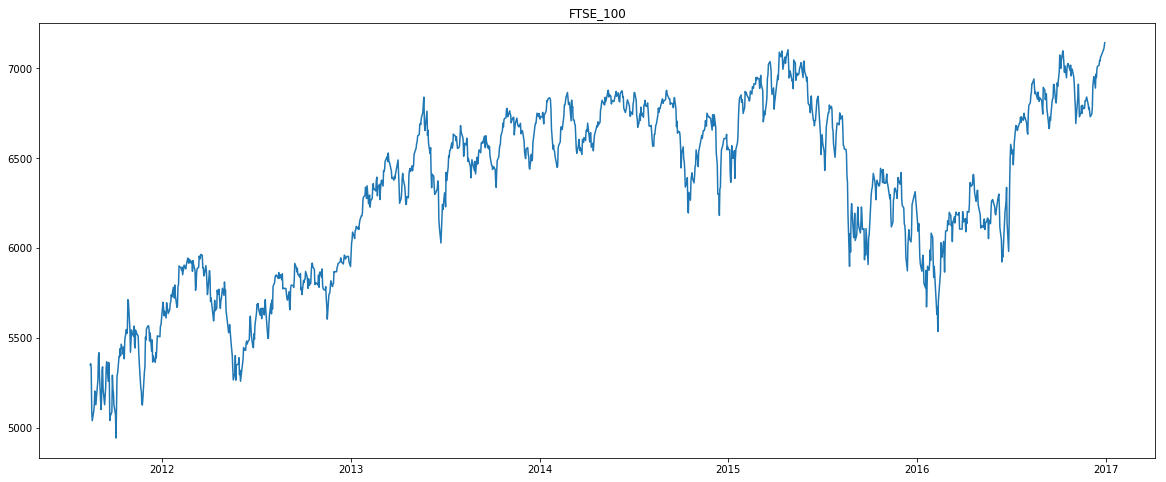

#### Gold #####
len: 3562
first 5: [(datetime.datetime(2003, 1, 2, 0, 0), 346.1), (datetime.datetime(2003, 1, 3, 0, 0), 351.2), (datetime.datetime(2003, 1, 6, 0, 0), 351.7), (datetime.datetime(2003, 1, 7, 0, 0), 347.3), (datetime.datetime(2003, 1, 8, 0, 0), 353.9)]
last 5: [(datetime.datetime(2016, 12, 26, 0, 0), 1134.55), (datetime.datetime(2016, 12, 27, 0, 0), 1137.3), (datetime.datetime(2016, 12, 28, 0, 0), 1139.4), (datetime.datetime(2016, 12, 29, 0, 0), 1156.4), (datetime.datetime(2016, 12, 30, 0, 0), 1150.0)]


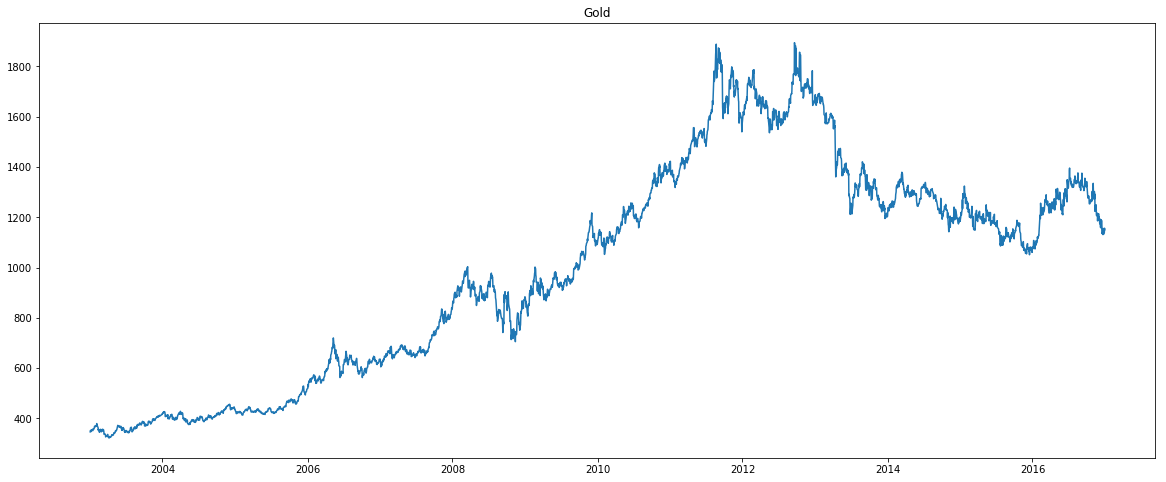

#### MSCI #####
len: 1170
first 5: [(datetime.datetime(2012, 7, 9, 0, 0), 309.48), (datetime.datetime(2012, 7, 10, 0, 0), 308.24), (datetime.datetime(2012, 7, 11, 0, 0), 308.17), (datetime.datetime(2012, 7, 12, 0, 0), 304.9), (datetime.datetime(2012, 7, 13, 0, 0), 309.4)]
last 5: [(datetime.datetime(2016, 12, 26, 0, 0), 422.39), (datetime.datetime(2016, 12, 27, 0, 0), 422.95), (datetime.datetime(2016, 12, 28, 0, 0), 421.11), (datetime.datetime(2016, 12, 29, 0, 0), 422.02), (datetime.datetime(2016, 12, 30, 0, 0), 421.84)]


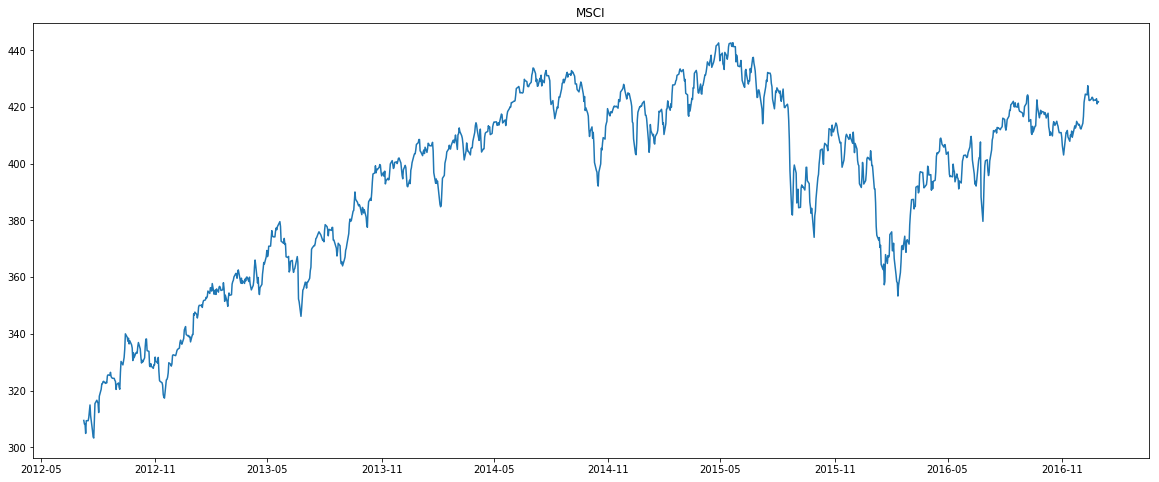

#### US_Dollar_Index #####
len: 2686
first 5: [(datetime.datetime(2007, 1, 31, 0, 0), 84.43), (datetime.datetime(2007, 2, 1, 0, 0), 84.46), (datetime.datetime(2007, 2, 2, 0, 0), 84.79), (datetime.datetime(2007, 2, 5, 0, 0), 84.92), (datetime.datetime(2007, 2, 6, 0, 0), 84.64)]
last 5: [(datetime.datetime(2016, 12, 23, 0, 0), 102.95), (datetime.datetime(2016, 12, 27, 0, 0), 103.0), (datetime.datetime(2016, 12, 28, 0, 0), 103.23), (datetime.datetime(2016, 12, 29, 0, 0), 102.66), (datetime.datetime(2016, 12, 30, 0, 0), 102.4)]


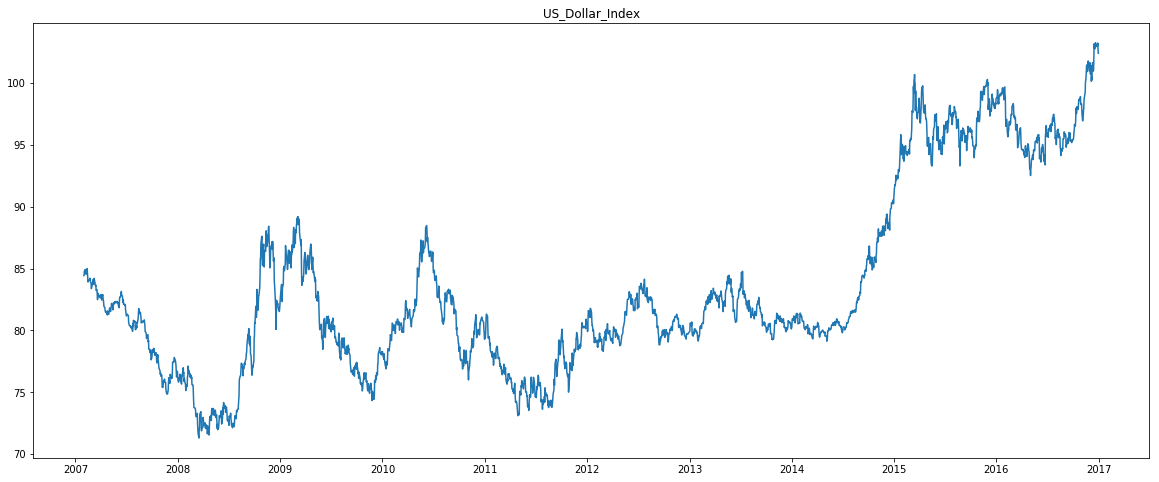

#### US_SmallCap_2000 #####
len: 3525
first 5: [(datetime.datetime(2003, 1, 2, 0, 0), 392.58), (datetime.datetime(2003, 1, 3, 0, 0), 390.31), (datetime.datetime(2003, 1, 6, 0, 0), 397.0), (datetime.datetime(2003, 1, 7, 0, 0), 393.95), (datetime.datetime(2003, 1, 8, 0, 0), 389.07)]
last 5: [(datetime.datetime(2016, 12, 23, 0, 0), 1371.51), (datetime.datetime(2016, 12, 27, 0, 0), 1377.71), (datetime.datetime(2016, 12, 28, 0, 0), 1360.83), (datetime.datetime(2016, 12, 29, 0, 0), 1363.18), (datetime.datetime(2016, 12, 30, 0, 0), 1357.13)]


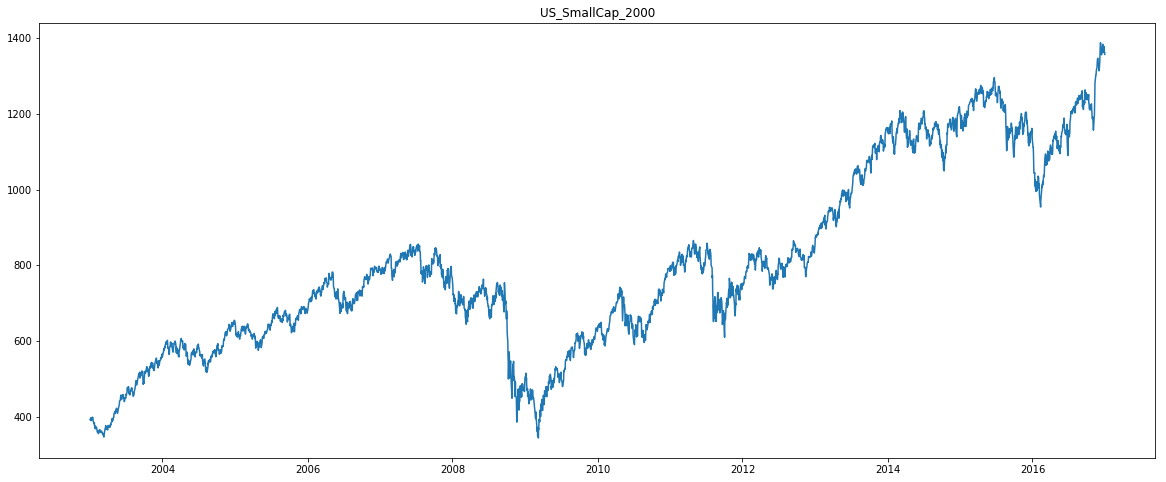

In [71]:
for i in range(len(new_factors)):
    print("####", new_factor_files[i].split(".", 1)[0] ,"#####")
    print("len:", len(new_factors[i]))
    print("first 5:", new_factors[i][:5])
    print("last 5:", new_factors[i][-5:])
    plot_factor(new_factors[i], new_factor_files[i].split(".", 1)[0])

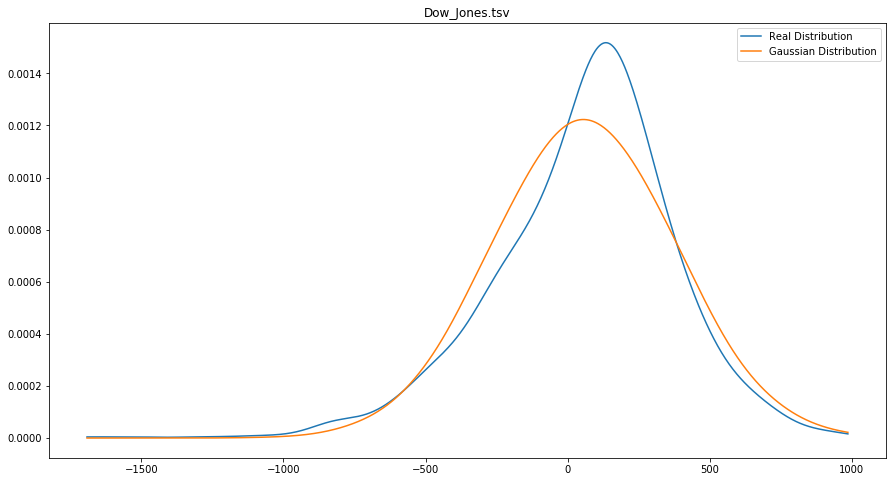

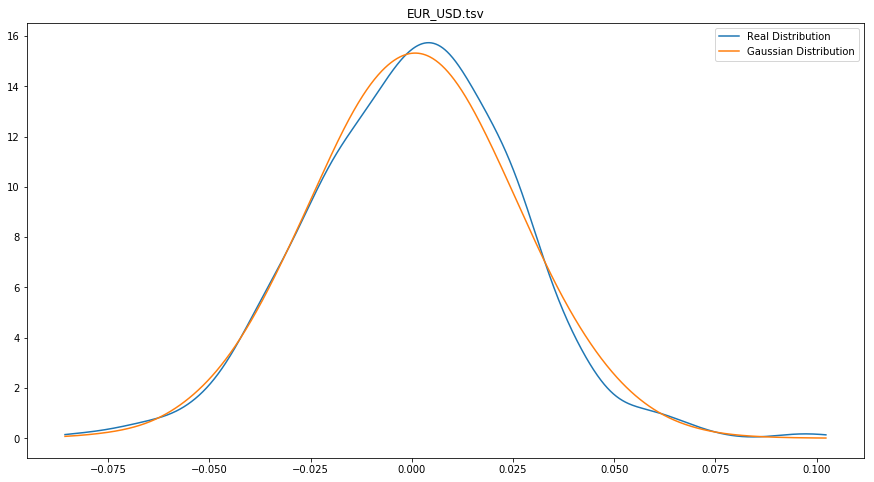

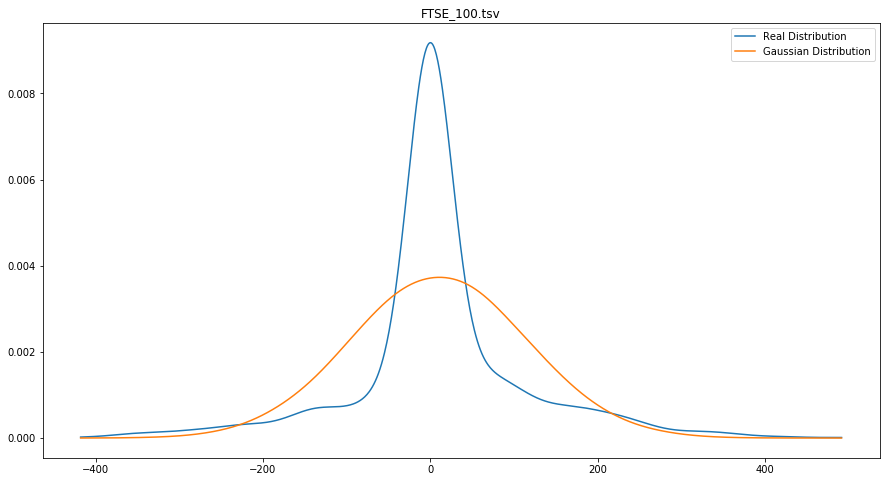

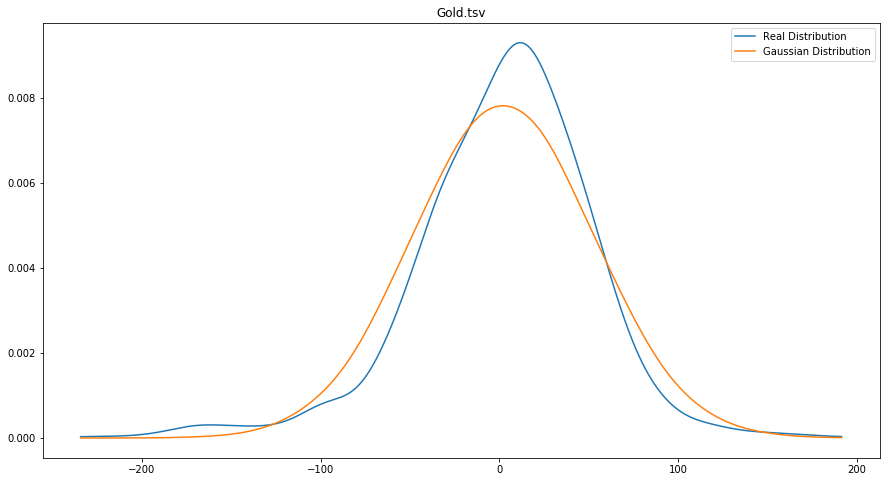

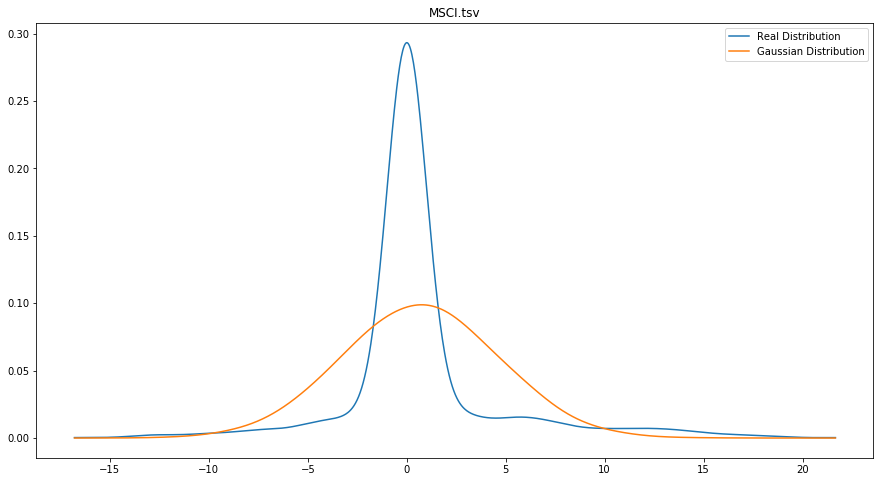

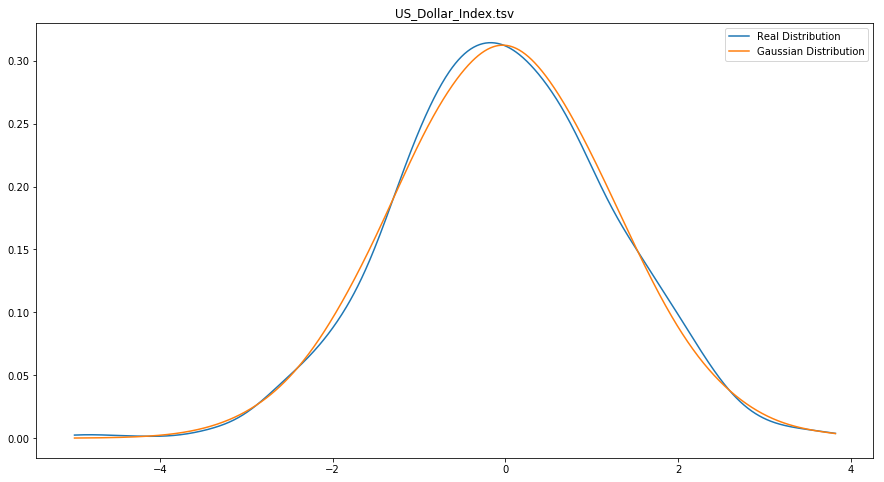

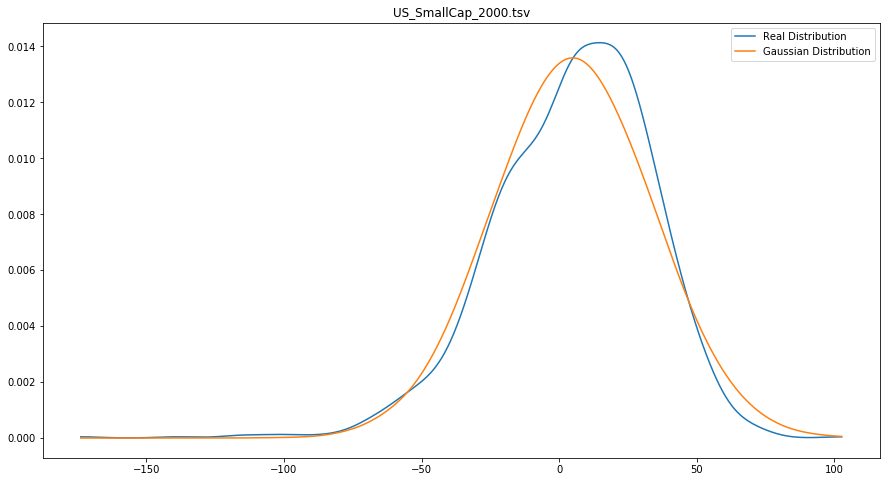

In [73]:
#Trim and compute the variance and the mean for the new set of 7 market factors
new_factors7 = trimInstrument(new_factors)
new_factors7 = list(map(twoWeekReturns, new_factors7))
new_factorCov_7 = np.cov(new_factors7)
new_factorMeans_7 = np.mean(new_factors7, axis=1)

samples = getDistributionSamples(100000, 7, np.random.multivariate_normal, new_factorMeans_7, new_factorCov_7)
for i in range(7):
    plotDistributions(new_factors7[i], samples[i], new_factor_files[i], 'Gaussian Distribution')

**COMMENT**<br>
As we said before we have added 7 new market factors in our dataset. These were not chosen randomly but we chosed them according to their importance in the determination of the global market trend. Most of them are indices that describes the performances of middle and big companies, but there are also the gold index and the EUR/USD exchange factor. Again we have chosed a multivariate normal distribution to approximate them and we can see that the major part can represent accurately the real distribution.

In [74]:
# merge the old and new factors (11 in total), trim each factor into a time region
# and fill up the missing values
allfactors_11f = factors1 + factors2 + new_factors
factors_11f = trimInstrument(allfactors_11f)
factorsReturns_11f = list(map(twoWeekReturns, factors_11f))
# estimate weights
weights_11f = computeWeights(stocksReturns, factorsReturns_11f)

In [75]:
factorCov_11f = np.cov(factorsReturns_11f)
factorMeans_11f = np.mean(factorsReturns_11f, axis=1)

valueAtRisk_11f, conditionalValueAtRisk_11f, trials_11f = MCSimulation(4, 10000, weights_11f, factorMeans_11f, factorCov_11f, 0, simulateTrialReturns)
printResults95(valueAtRisk_11f, conditionalValueAtRisk_11f, trials_11f, stocksReturns)

Value at Risk(VaR) 5%: -20.68721037567237
Conditional Value at Risk(CVaR) 5%: -27.676225903295318

VaR confidence interval:  (-20.722173833032652, -21.18881825142446)
CVaR confidence interval:  (-27.415816541224025, -27.255772742929334)
num failures: 107
Kupiec test p-value:  7.590669407276691e-07


**COMMENT**<br>
Looking at the values of the Var, CVar and kupiec test result we can not see a significant difference from the ones we obtained analyzing only 4 factors. This is not exactly what we expected; it was expected a large impovement since we have increased the knowledge base that we have about market stocks.

In [76]:
#Compute and print the correlation matrix among all market factors
correlation = np.corrcoef(factorsReturns_11f)
print("Row 0: Crude Oil")
print("Row 1: US Treasury Bond")
print("Row 2: GSPC")
print("Row 3: IXIC")
for idx, elem in enumerate(new_factor_files):
    print("Row", str(idx+4) + ":", elem.split(".")[0])
print("Correlations:\n", correlation)

Row 0: Crude Oil
Row 1: US Treasury Bond
Row 2: GSPC
Row 3: IXIC
Row 4: Dow_Jones
Row 5: EUR_USD
Row 6: FTSE_100
Row 7: Gold
Row 8: MSCI
Row 9: US_Dollar_Index
Row 10: US_SmallCap_2000
Correlations:
 [[ 1.          0.38788549  0.47411609  0.45841194  0.44355352  0.41144909
   0.23457222  0.25136829  0.09882924 -0.41637228  0.46522898]
 [ 0.38788549  1.          0.58447669  0.58306416  0.55101978  0.28815609
   0.32705297  0.01346539  0.17307725 -0.27929036  0.57322945]
 [ 0.47411609  0.58447669  1.          0.95227596  0.97513069  0.44702413
   0.52358072  0.124617    0.41244725 -0.45383032  0.93649605]
 [ 0.45841194  0.58306416  0.95227596  1.          0.89893182  0.40883243
   0.50861838  0.13349311  0.39794367 -0.41120124  0.94155878]
 [ 0.44355352  0.55101978  0.97513069  0.89893182  1.          0.43753663
   0.51853925  0.10759178  0.40575357 -0.44422216  0.89191619]
 [ 0.41144909  0.28815609  0.44702413  0.40883243  0.43753663  1.
   0.13203012  0.27571134  0.15463646 -0.95942431

Text(86.0938,0.5,'Factors')

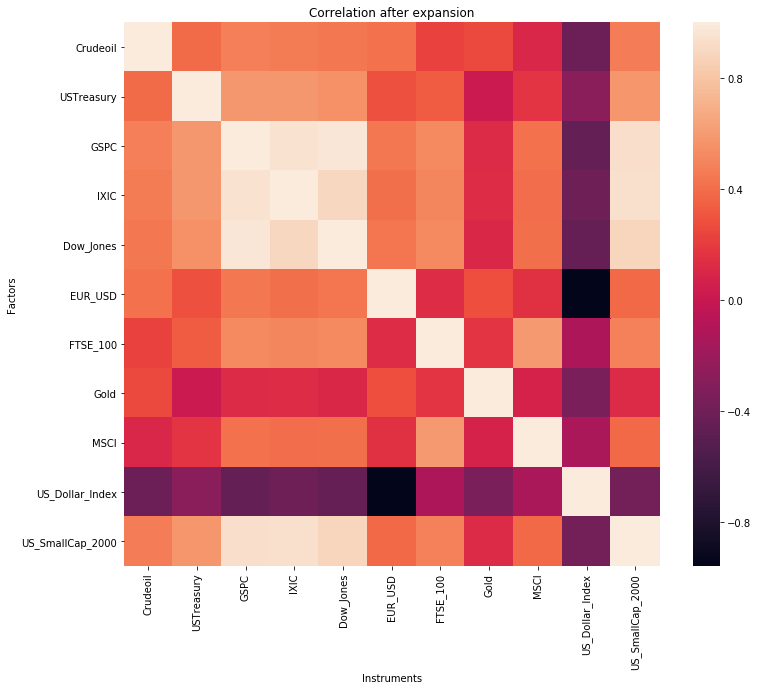

In [77]:
# Plot the same correlation matrix above with a heat map
fig, ax = plt.subplots(figsize=(12,10))         # Sample figsize in inches
new_factor_elems = [elem.split(".")[0] for elem in new_factor_files]
labels = factor_names+new_factor_elems
sns.heatmap(correlation, yticklabels=labels, xticklabels=labels, ax=ax)
ax.set_title('Correlation after expansion')
ax.set_xlabel('Instruments')
ax.set_ylabel('Factors')

**COMMENT**<br>
By looking at the correlation heat map we can obviously see again the same correlations we had at the beginning of the notebook on the 4 initial market factors (CrudeOil, IXIC, GSPC, USTreasuryBonds).

In addition to this is possible to analyze other factor combinations, and among the newest added values there are some with a very high correlation: for example the US_SmallCap_2000 is highly correlated to 3 other factors (GSPC, IXIC and Dow Jones).

## 6.2 More Years

We have decided to complete our analysis by computing a MonteCarlo simulation considering 10 years of market stocks data, instead of 5. 

In [78]:
start_=datetime(year=2004, month=1, day=23)
end_=datetime(year=2014, month=1, day=23)

factors_10y = trimInstrument(allfactors, start_, end_)
factorsReturns_10y = list(map(twoWeekReturns, factors_10y))

rawStocks_10y = readStocks(45, 10, stock_folder)
stocks_10y = trimInstrument(rawStocks_10y, start_, end_)
stocksReturns_10y = computeStockTwoWeekReturn(stocks_10y)
weights_10y = computeWeights(stocksReturns_10y, factorsReturns_10y)

Initial number of stocks:  45
Number of used stocks:  29



In [79]:
factorCov_10y = np.cov(factorsReturns_10y)
factorMeans_10y = np.mean(factorsReturns_10y, axis=1)

valueAtRisk_10y, conditionalValueAtRisk_10y, trials_10y = MCSimulation(4, 10000, weights_10y, factorMeans_10y, factorCov_10y, 0, simulateTrialReturns)
printResults95(valueAtRisk_10y, conditionalValueAtRisk_10y, trials_10y, stocksReturns_10y)

Value at Risk(VaR) 5%: -24.11114915603749
Conditional Value at Risk(CVaR) 5%: -29.99856114129859

VaR confidence interval:  (-24.214715827473597, -24.052833030569378)
CVaR confidence interval:  (-29.831891700326977, -30.20518632633513)
num failures: 225
Kupiec test p-value:  7.150421571877159e-15


**COMMENT**<br>
In this section we have tried investing in an equal number of stocks with respect to the initial analysis we did at the beginning of this notebook. In fact, after the trimming phase, we end up with 29 stocks. This time we have considered 10 years of time series data. What we expected was an improvement in the result, because usually with more data we can approximate better the stock trends, but actually we obtained a worsening. This may have happened because we are investing in different stocks, in fact we have had to specify an initial number of stocks of 45 (instead of 35) to get at the end 29 stocks with at least 10 years of data. Another reason may be the fact that in the time interval between 2004 and 2014 there were some important events that lead to a crisis in the market and that are not good to build a prediction model: an example could be the great recession that started in december 2007.

# 7. Summary
In this lecture, we studied the Monte Carlo Simulation method and its application to estimate financial risk. To apply it, first, we needed to define the relationship between market factors and the instruments' returns. In such step, you must define the model which maps the market factors' values to the instruments' values: in our use case, we used a linear regression function for building our model. Next, we also had to find the parameters of our model, which are the weights of the factors we considered. Then, we had to study the distribution of each market factor. A good way to do that is using Kernel density estimation to smooth the distribution and plot it. Depending on the shape of each figure, we had to guess the best fit distribution for each factor: in our use case, we used a very simple approach, and decided that our smoothed distributions all looked normal distributions. 

Then, the idea of Monte Carlo simulation was to generate many possible values for each factor and calculate the corresponding outcomes by a well-defined model in each trial. After many trials, we were able to calculate VaR from the sequences of outcome's values. When the number of trials is large enough, the VaR converges to reasonable values, that we could validate using well-known statistical hypothesis. 

# References
- The example in section 2 is inspired from [this article](http://www.solver.com/monte-carlo-simulation-example).
- [Backtesting Value-at-Risk models](https://aaltodoc.aalto.fi/bitstream/handle/123456789/181/hse_ethesis_12049.pdf?sequence=1) (Kansantaloustiede, 2009) - (A good reference to study Backtesting).
